In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import matplotlib.pyplot as plt
import os
%matplotlib qt
%matplotlib inline
plt.style.use('seaborn')

In [93]:
from helpers import *
from util import *

# Data exploration

In [31]:
cars_path_small = '../vehicle_detect/vehicles_smallset/**/'
noncars_path_small = '../vehicle_detect/non-vehicles_smallset/**/'

In [32]:
car_list = get_img_list_from_path(cars_path_small)
noncar_list = get_img_list_from_path(noncars_path_small)

In [83]:
example, data_description = peek_data(car_list, noncar_list)

print(data_description)

{'image_shape': (64, 64, 3), 'n_notcars': 1125, 'data_type': dtype('uint8'), 'n_cars': 1196}


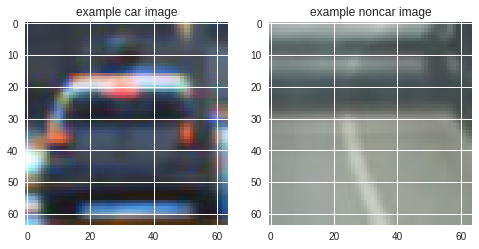

In [84]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(example['cars'])
plt.title('example car image')
plt.subplot(122)
plt.imshow(example['noncars'])
plt.title('example noncar image')

# Data preprocessing

## explore HOG parameters

/home/boliu1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


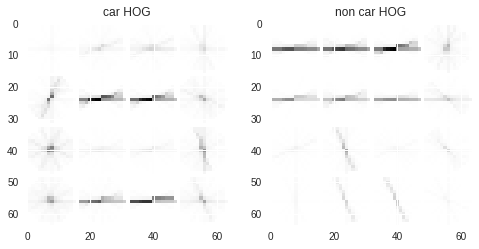

In [94]:
example_features_car, example_hog_img_car = get_hog_features_from_rgb_img(example['cars'], 
                                        orient=32, pix_per_cell=16, vis=True)
example_features_noncar, example_hog_img_noncar = get_hog_features_from_rgb_img(example['noncars'], 
                                        orient=32, pix_per_cell=16, vis=True)

fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(example_hog_img_car)
plt.title('car HOG')

plt.subplot(122)
plt.imshow(example_hog_img_noncar)
plt.title('non car HOG')

## explore color parameters

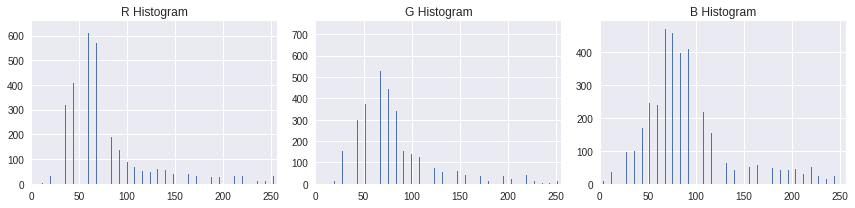

In [87]:
image_test = example['cars']

rh, gh, bh, bincen, feature_vec = color_hist(image_test, nbins=32, bins_range=(0, 256))
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()

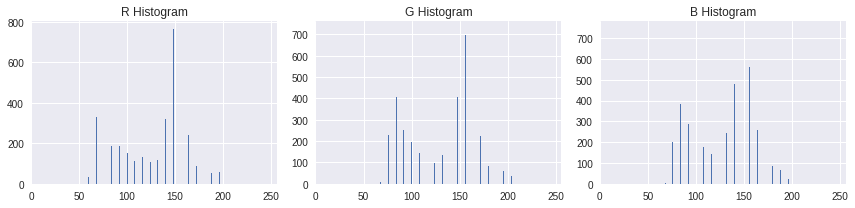

In [88]:
image_test = example['noncars']

rh, gh, bh, bincen, feature_vec = color_hist(image_test, nbins=32, bins_range=(0, 256))
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()

## Using HSV channels

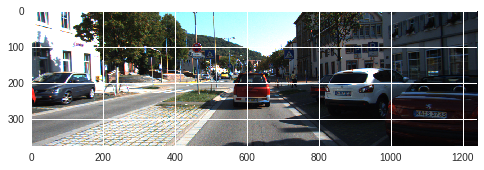

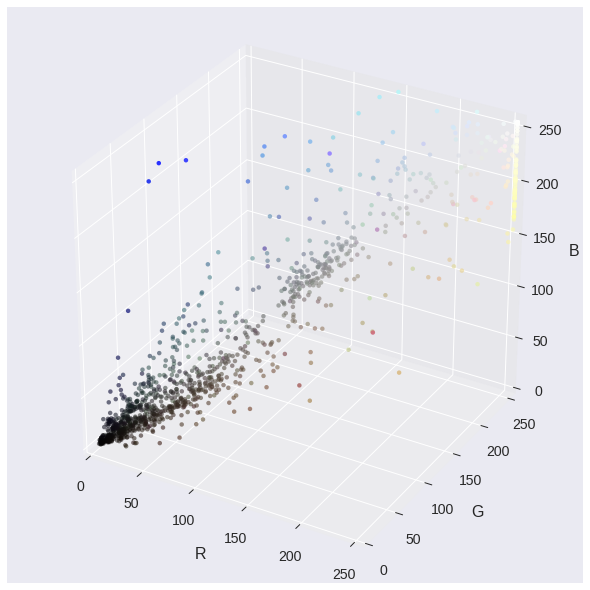

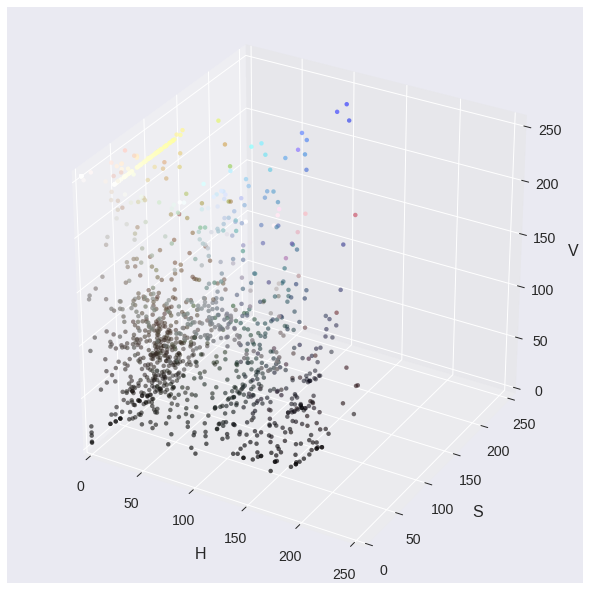

In [91]:
# Read a color image
img = cv2.imread("./test_images/000275.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

# Feature extraction

In [97]:
import pickle

with open("X_train.p", mode='rb') as f:
        X_train = pickle.load(f)

with open("y_train.p", mode='rb') as f:
        y_train = pickle.load(f)

with open("X_test.p", mode='rb') as f:
        X_test = pickle.load(f)

with open("y_test.p", mode='rb') as f:
        y_test = pickle.load(f)

In [105]:
car_ind = np.random.randint(0, len(X_train))
print(car_ind)

print(X_train[0].shape)

4838
(4320,)


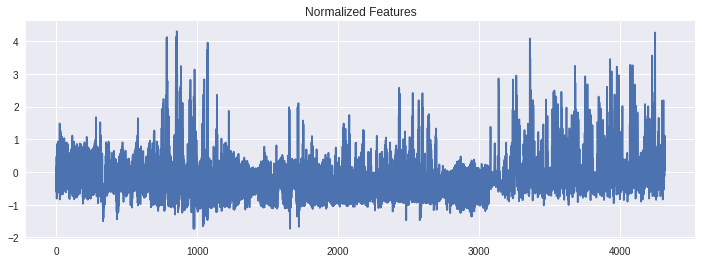

In [107]:
fig = plt.figure(figsize=(12,4))
plt.subplot(111)
plt.plot(X_train[0])
plt.title('Normalized Features')

# Parameter tuning for training

# Application on the project video

In [44]:
def annotate_img(img):
    global heatmap_cache, clf, X_scaler
    win_128 = slide_window(img, xy_window=(128, 128), xy_overlap=(0.8, 0.8))
    win_64 = slide_window(img, xy_window=(64, 64), xy_overlap=(0.8, 0.8))

    img_out = np.copy(img)

    on_win_128 = search_windows(img, win_128, clf, X_scaler, orient=9, pix_per_cell=8, color_space='HLS', hist_bins=32,hog_channel='ALL',spatial_feat=False, spatial_size=(16,16))
    on_win_64 = search_windows(img, win_64, clf, X_scaler, orient=9, pix_per_cell=8, color_space='HLS', hist_bins=32,hog_channel='ALL',spatial_feat=False, spatial_size=(16,16))

    all_on_windows = on_win_128 + on_win_64

    print('num on windows: ', len(all_on_windows))
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.uint8)
    heatmap = add_heat(heatmap, all_on_windows)

    heatmap_cache.append(heatmap)
    heatmap_graph = apply_threshold(sum(heatmap_cache), 8)
    heatmap_graph = np.clip(heatmap_graph, 0, 255)
    labels = label(heatmap_graph)
    img_out = draw_labeled_bboxes(img_out, labels)
    #img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)

    return img_out

In [45]:
from util import *
from helpers import *
from scipy.ndimage.measurements import label
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML


with open('LinearSVC_trained.p', 'rb') as file:
    clf = pickle.load(file)

with open('X_scaler.p', 'rb') as file:
    X_scaler = pickle.load(file)

heatmap_cache = deque(maxlen=10)

output = 'output_images/project-video-processed-0.8.mp4'
clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.fl_image(annotate_img) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

num on windows:  1
[MoviePy] >>>> Building video output_images/project-video-processed-0.8.mp4
[MoviePy] Writing video output_images/project-video-processed-0.8.mp4



  0%|          | 1/1261 [00:13<4:46:57, 13.67s/it]

num on windows:  1



  0%|          | 2/1261 [00:27<4:46:37, 13.66s/it]

num on windows:  0



  0%|          | 3/1261 [00:41<4:47:03, 13.69s/it]

num on windows:  0



  0%|          | 4/1261 [00:55<4:50:44, 13.88s/it]

num on windows:  1



  0%|          | 5/1261 [01:09<4:52:07, 13.96s/it]

num on windows:  0



  0%|          | 6/1261 [01:23<4:53:25, 14.03s/it]

num on windows:  0



  1%|          | 7/1261 [01:38<4:54:51, 14.11s/it]

num on windows:  0



  1%|          | 8/1261 [01:52<4:55:10, 14.13s/it]

num on windows:  0



  1%|          | 9/1261 [02:06<4:55:48, 14.18s/it]

num on windows:  0



  1%|          | 10/1261 [02:20<4:53:15, 14.07s/it]

num on windows:  0



  1%|          | 11/1261 [02:34<4:52:55, 14.06s/it]

num on windows:  0



  1%|          | 12/1261 [02:49<4:58:30, 14.34s/it]

num on windows:  0



  1%|          | 13/1261 [03:03<4:59:55, 14.42s/it]

num on windows:  0



  1%|          | 14/1261 [03:18<5:00:57, 14.48s/it]

num on windows:  0



  1%|          | 15/1261 [03:33<5:02:04, 14.55s/it]

num on windows:  0



  1%|▏         | 16/1261 [03:48<5:03:27, 14.62s/it]

num on windows:  0



  1%|▏         | 17/1261 [04:02<5:02:39, 14.60s/it]

num on windows:  0



  1%|▏         | 18/1261 [04:17<5:02:09, 14.59s/it]

num on windows:  0



  2%|▏         | 19/1261 [04:31<5:01:51, 14.58s/it]

num on windows:  0



  2%|▏         | 20/1261 [04:46<5:00:45, 14.54s/it]

num on windows:  0



  2%|▏         | 21/1261 [05:02<5:09:16, 14.96s/it]

num on windows:  0



  2%|▏         | 22/1261 [05:17<5:08:27, 14.94s/it]

num on windows:  1



  2%|▏         | 23/1261 [05:31<5:03:37, 14.72s/it]

num on windows:  0



  2%|▏         | 24/1261 [05:45<5:01:26, 14.62s/it]

num on windows:  0



  2%|▏         | 25/1261 [06:00<5:00:11, 14.57s/it]

num on windows:  0



  2%|▏         | 26/1261 [06:14<4:59:13, 14.54s/it]

num on windows:  0



  2%|▏         | 27/1261 [06:28<4:58:29, 14.51s/it]

num on windows:  0



  2%|▏         | 28/1261 [06:43<4:56:59, 14.45s/it]

num on windows:  0



  2%|▏         | 29/1261 [06:57<4:58:07, 14.52s/it]

num on windows:  0



  2%|▏         | 30/1261 [07:12<4:58:46, 14.56s/it]

num on windows:  0



  2%|▏         | 31/1261 [07:27<4:58:59, 14.58s/it]

num on windows:  0



  3%|▎         | 32/1261 [07:41<4:57:45, 14.54s/it]

num on windows:  0



  3%|▎         | 33/1261 [07:55<4:55:43, 14.45s/it]

num on windows:  0



  3%|▎         | 34/1261 [08:10<4:56:54, 14.52s/it]

num on windows:  0



  3%|▎         | 35/1261 [08:24<4:55:45, 14.47s/it]

num on windows:  0



  3%|▎         | 36/1261 [08:39<4:55:57, 14.50s/it]

num on windows:  0



  3%|▎         | 37/1261 [08:54<4:56:27, 14.53s/it]

num on windows:  0



  3%|▎         | 38/1261 [09:08<4:56:07, 14.53s/it]

num on windows:  0



  3%|▎         | 39/1261 [09:23<4:59:57, 14.73s/it]

num on windows:  0



  3%|▎         | 40/1261 [09:38<5:01:06, 14.80s/it]

num on windows:  0



  3%|▎         | 41/1261 [09:53<4:58:59, 14.70s/it]

num on windows:  0



  3%|▎         | 42/1261 [10:07<4:56:29, 14.59s/it]

num on windows:  1



  3%|▎         | 43/1261 [10:22<5:00:23, 14.80s/it]

num on windows:  0



  3%|▎         | 44/1261 [10:38<5:05:00, 15.04s/it]

num on windows:  0



  4%|▎         | 45/1261 [10:53<5:05:42, 15.08s/it]

num on windows:  0



  4%|▎         | 46/1261 [11:09<5:10:40, 15.34s/it]

num on windows:  0



  4%|▎         | 47/1261 [11:25<5:11:58, 15.42s/it]

num on windows:  0



  4%|▍         | 48/1261 [11:40<5:10:29, 15.36s/it]

num on windows:  0



  4%|▍         | 49/1261 [11:55<5:08:45, 15.29s/it]

num on windows:  0



  4%|▍         | 50/1261 [12:10<5:05:07, 15.12s/it]

num on windows:  0



  4%|▍         | 51/1261 [12:26<5:09:48, 15.36s/it]

num on windows:  0



  4%|▍         | 52/1261 [12:41<5:07:15, 15.25s/it]

num on windows:  0



  4%|▍         | 53/1261 [12:56<5:08:23, 15.32s/it]

num on windows:  0



  4%|▍         | 54/1261 [13:12<5:08:25, 15.33s/it]

num on windows:  0



  4%|▍         | 55/1261 [13:27<5:07:53, 15.32s/it]

num on windows:  0



  4%|▍         | 56/1261 [13:42<5:07:35, 15.32s/it]

num on windows:  0



  5%|▍         | 57/1261 [13:57<5:05:27, 15.22s/it]

num on windows:  0



  5%|▍         | 58/1261 [14:13<5:06:00, 15.26s/it]

num on windows:  0



  5%|▍         | 59/1261 [14:27<5:03:42, 15.16s/it]

num on windows:  0



  5%|▍         | 60/1261 [14:43<5:03:34, 15.17s/it]

num on windows:  1



  5%|▍         | 61/1261 [14:58<5:05:44, 15.29s/it]

num on windows:  0



  5%|▍         | 62/1261 [15:13<5:05:05, 15.27s/it]

num on windows:  0



  5%|▍         | 63/1261 [15:29<5:09:31, 15.50s/it]

num on windows:  0



  5%|▌         | 64/1261 [15:45<5:07:26, 15.41s/it]

num on windows:  0



  5%|▌         | 65/1261 [15:59<5:02:48, 15.19s/it]

num on windows:  0



  5%|▌         | 66/1261 [16:14<4:59:50, 15.05s/it]

num on windows:  0



  5%|▌         | 67/1261 [16:30<5:01:57, 15.17s/it]

num on windows:  0



  5%|▌         | 68/1261 [16:45<5:01:50, 15.18s/it]

num on windows:  1



  5%|▌         | 69/1261 [17:00<5:01:35, 15.18s/it]

num on windows:  0



  6%|▌         | 70/1261 [17:15<5:01:21, 15.18s/it]

num on windows:  0



  6%|▌         | 71/1261 [17:30<5:00:46, 15.16s/it]

num on windows:  0



  6%|▌         | 72/1261 [17:45<4:59:21, 15.11s/it]

num on windows:  1



  6%|▌         | 73/1261 [18:00<4:59:40, 15.14s/it]

num on windows:  1



  6%|▌         | 74/1261 [18:16<5:00:36, 15.20s/it]

num on windows:  0



  6%|▌         | 75/1261 [18:31<5:00:05, 15.18s/it]

num on windows:  1



  6%|▌         | 76/1261 [18:46<5:00:06, 15.20s/it]

num on windows:  0



  6%|▌         | 77/1261 [19:02<5:05:44, 15.49s/it]

num on windows:  0



  6%|▌         | 78/1261 [19:18<5:03:59, 15.42s/it]

num on windows:  0



  6%|▋         | 79/1261 [19:33<5:03:14, 15.39s/it]

num on windows:  0



  6%|▋         | 80/1261 [19:48<5:03:27, 15.42s/it]

num on windows:  0



  6%|▋         | 81/1261 [20:03<5:01:36, 15.34s/it]

num on windows:  0



  7%|▋         | 82/1261 [20:19<5:02:25, 15.39s/it]

num on windows:  0



  7%|▋         | 83/1261 [20:34<5:01:02, 15.33s/it]

num on windows:  1



  7%|▋         | 84/1261 [20:49<4:59:10, 15.25s/it]

num on windows:  1



  7%|▋         | 85/1261 [21:04<4:58:41, 15.24s/it]

num on windows:  0



  7%|▋         | 86/1261 [21:19<4:56:32, 15.14s/it]

num on windows:  0



  7%|▋         | 87/1261 [21:35<5:00:17, 15.35s/it]

num on windows:  0



  7%|▋         | 88/1261 [21:51<5:01:44, 15.43s/it]

num on windows:  0



  7%|▋         | 89/1261 [22:07<5:03:31, 15.54s/it]

num on windows:  0



  7%|▋         | 90/1261 [22:21<4:57:53, 15.26s/it]

num on windows:  0



  7%|▋         | 91/1261 [22:36<4:54:06, 15.08s/it]

num on windows:  0



  7%|▋         | 92/1261 [22:50<4:49:48, 14.88s/it]

num on windows:  0



  7%|▋         | 93/1261 [23:05<4:48:14, 14.81s/it]

num on windows:  0



  7%|▋         | 94/1261 [23:19<4:46:16, 14.72s/it]

num on windows:  0



  8%|▊         | 95/1261 [23:34<4:45:07, 14.67s/it]

num on windows:  0



  8%|▊         | 96/1261 [23:49<4:45:58, 14.73s/it]

num on windows:  0



  8%|▊         | 97/1261 [24:04<4:50:39, 14.98s/it]

num on windows:  0



  8%|▊         | 98/1261 [24:20<4:53:29, 15.14s/it]

num on windows:  0



  8%|▊         | 99/1261 [24:36<4:57:52, 15.38s/it]

num on windows:  0



  8%|▊         | 100/1261 [24:52<4:59:51, 15.50s/it]

num on windows:  0



  8%|▊         | 101/1261 [25:07<4:59:16, 15.48s/it]

num on windows:  0



  8%|▊         | 102/1261 [25:22<4:56:26, 15.35s/it]

num on windows:  0



  8%|▊         | 103/1261 [25:37<4:55:33, 15.31s/it]

num on windows:  0



  8%|▊         | 104/1261 [25:53<4:55:55, 15.35s/it]

num on windows:  0



  8%|▊         | 105/1261 [26:08<4:55:10, 15.32s/it]

num on windows:  0



  8%|▊         | 106/1261 [26:23<4:52:10, 15.18s/it]

num on windows:  0



  8%|▊         | 107/1261 [26:37<4:48:13, 14.99s/it]

num on windows:  0



  9%|▊         | 108/1261 [26:52<4:45:25, 14.85s/it]

num on windows:  0



  9%|▊         | 109/1261 [27:06<4:43:00, 14.74s/it]

num on windows:  0



  9%|▊         | 110/1261 [27:21<4:41:36, 14.68s/it]

num on windows:  1



  9%|▉         | 111/1261 [27:36<4:40:18, 14.62s/it]

num on windows:  2



  9%|▉         | 112/1261 [27:50<4:41:42, 14.71s/it]

num on windows:  2



  9%|▉         | 113/1261 [28:05<4:41:22, 14.71s/it]

num on windows:  2



  9%|▉         | 114/1261 [28:20<4:40:12, 14.66s/it]

num on windows:  1



  9%|▉         | 115/1261 [28:34<4:39:40, 14.64s/it]

num on windows:  1



  9%|▉         | 116/1261 [28:49<4:39:26, 14.64s/it]

num on windows:  0



  9%|▉         | 117/1261 [29:04<4:40:05, 14.69s/it]

num on windows:  1



  9%|▉         | 118/1261 [29:19<4:40:52, 14.74s/it]

num on windows:  0



  9%|▉         | 119/1261 [29:33<4:40:40, 14.75s/it]

num on windows:  0



 10%|▉         | 120/1261 [29:48<4:40:29, 14.75s/it]

num on windows:  2



 10%|▉         | 121/1261 [30:03<4:43:50, 14.94s/it]

num on windows:  0



 10%|▉         | 122/1261 [30:18<4:42:25, 14.88s/it]

num on windows:  0



 10%|▉         | 123/1261 [30:33<4:40:55, 14.81s/it]

num on windows:  2



 10%|▉         | 124/1261 [30:48<4:39:49, 14.77s/it]

num on windows:  2



 10%|▉         | 125/1261 [31:02<4:39:11, 14.75s/it]

num on windows:  0



 10%|▉         | 126/1261 [31:17<4:37:49, 14.69s/it]

num on windows:  1



 10%|█         | 127/1261 [31:32<4:38:20, 14.73s/it]

num on windows:  2



 10%|█         | 128/1261 [31:46<4:37:05, 14.67s/it]

num on windows:  1



 10%|█         | 129/1261 [32:01<4:37:58, 14.73s/it]

num on windows:  2



 10%|█         | 130/1261 [32:16<4:39:06, 14.81s/it]

num on windows:  1



 10%|█         | 131/1261 [32:31<4:38:22, 14.78s/it]

num on windows:  2



 10%|█         | 132/1261 [32:46<4:40:05, 14.89s/it]

num on windows:  3



 11%|█         | 133/1261 [33:01<4:40:57, 14.94s/it]

num on windows:  1



 11%|█         | 134/1261 [33:16<4:41:10, 14.97s/it]

num on windows:  2



 11%|█         | 135/1261 [33:31<4:42:08, 15.03s/it]

num on windows:  2



 11%|█         | 136/1261 [33:46<4:41:10, 15.00s/it]

num on windows:  2



 11%|█         | 137/1261 [34:01<4:40:19, 14.96s/it]

num on windows:  2



 11%|█         | 138/1261 [34:16<4:39:45, 14.95s/it]

num on windows:  3



 11%|█         | 139/1261 [34:31<4:38:48, 14.91s/it]

num on windows:  2



 11%|█         | 140/1261 [34:45<4:37:01, 14.83s/it]

num on windows:  1



 11%|█         | 141/1261 [35:00<4:36:20, 14.80s/it]

num on windows:  0



 11%|█▏        | 142/1261 [35:15<4:35:34, 14.78s/it]

num on windows:  0



 11%|█▏        | 143/1261 [35:30<4:35:07, 14.77s/it]

num on windows:  0



 11%|█▏        | 144/1261 [35:45<4:38:20, 14.95s/it]

num on windows:  2



 11%|█▏        | 145/1261 [36:00<4:40:17, 15.07s/it]

num on windows:  0



 12%|█▏        | 146/1261 [36:15<4:41:01, 15.12s/it]

num on windows:  1



 12%|█▏        | 147/1261 [36:31<4:40:27, 15.11s/it]

num on windows:  4



 12%|█▏        | 148/1261 [36:45<4:38:55, 15.04s/it]

num on windows:  1



 12%|█▏        | 149/1261 [37:01<4:39:42, 15.09s/it]

num on windows:  3



 12%|█▏        | 150/1261 [37:16<4:38:27, 15.04s/it]

num on windows:  0



 12%|█▏        | 151/1261 [37:30<4:36:52, 14.97s/it]

num on windows:  0



 12%|█▏        | 152/1261 [37:45<4:34:58, 14.88s/it]

num on windows:  0



 12%|█▏        | 153/1261 [38:00<4:33:12, 14.79s/it]

num on windows:  1



 12%|█▏        | 154/1261 [38:14<4:31:13, 14.70s/it]

num on windows:  1



 12%|█▏        | 155/1261 [38:29<4:31:52, 14.75s/it]

num on windows:  3



 12%|█▏        | 156/1261 [38:44<4:31:09, 14.72s/it]

num on windows:  2



 12%|█▏        | 157/1261 [38:58<4:30:33, 14.70s/it]

num on windows:  3



 13%|█▎        | 158/1261 [39:13<4:30:06, 14.69s/it]

num on windows:  2



 13%|█▎        | 159/1261 [39:28<4:29:35, 14.68s/it]

num on windows:  4



 13%|█▎        | 160/1261 [39:43<4:31:47, 14.81s/it]

num on windows:  5



 13%|█▎        | 161/1261 [39:57<4:30:59, 14.78s/it]

num on windows:  4



 13%|█▎        | 162/1261 [40:12<4:30:01, 14.74s/it]

num on windows:  10



 13%|█▎        | 163/1261 [40:27<4:30:01, 14.76s/it]

num on windows:  6



 13%|█▎        | 164/1261 [40:41<4:28:50, 14.70s/it]

num on windows:  9



 13%|█▎        | 165/1261 [40:56<4:27:53, 14.67s/it]

num on windows:  8



 13%|█▎        | 166/1261 [41:11<4:26:47, 14.62s/it]

num on windows:  7



 13%|█▎        | 167/1261 [41:25<4:25:15, 14.55s/it]

num on windows:  9



 13%|█▎        | 168/1261 [41:39<4:24:33, 14.52s/it]

num on windows:  6



 13%|█▎        | 169/1261 [41:54<4:24:33, 14.54s/it]

num on windows:  8



 13%|█▎        | 170/1261 [42:08<4:22:31, 14.44s/it]

num on windows:  6



 14%|█▎        | 171/1261 [42:22<4:19:25, 14.28s/it]

num on windows:  9



 14%|█▎        | 172/1261 [42:36<4:16:49, 14.15s/it]

num on windows:  13



 14%|█▎        | 173/1261 [42:49<4:13:15, 13.97s/it]

num on windows:  9



 14%|█▍        | 174/1261 [43:03<4:10:38, 13.83s/it]

num on windows:  9



 14%|█▍        | 175/1261 [43:17<4:08:42, 13.74s/it]

num on windows:  7



 14%|█▍        | 176/1261 [43:31<4:10:33, 13.86s/it]

num on windows:  9



 14%|█▍        | 177/1261 [43:45<4:12:52, 14.00s/it]

num on windows:  8



 14%|█▍        | 178/1261 [43:59<4:14:52, 14.12s/it]

num on windows:  5



 14%|█▍        | 179/1261 [44:13<4:14:34, 14.12s/it]

num on windows:  10



 14%|█▍        | 180/1261 [44:28<4:15:47, 14.20s/it]

num on windows:  9



 14%|█▍        | 181/1261 [44:42<4:15:49, 14.21s/it]

num on windows:  7



 14%|█▍        | 182/1261 [44:56<4:14:53, 14.17s/it]

num on windows:  5



 15%|█▍        | 183/1261 [45:11<4:15:18, 14.21s/it]

num on windows:  6



 15%|█▍        | 184/1261 [45:25<4:14:42, 14.19s/it]

num on windows:  7



 15%|█▍        | 185/1261 [45:39<4:13:23, 14.13s/it]

num on windows:  8



 15%|█▍        | 186/1261 [45:53<4:15:34, 14.26s/it]

num on windows:  6



 15%|█▍        | 187/1261 [46:09<4:21:12, 14.59s/it]

num on windows:  10



 15%|█▍        | 188/1261 [46:24<4:27:45, 14.97s/it]

num on windows:  9



 15%|█▍        | 189/1261 [46:40<4:29:16, 15.07s/it]

num on windows:  11



 15%|█▌        | 190/1261 [46:55<4:28:23, 15.04s/it]

num on windows:  10



 15%|█▌        | 191/1261 [47:09<4:26:21, 14.94s/it]

num on windows:  6



 15%|█▌        | 192/1261 [47:24<4:23:41, 14.80s/it]

num on windows:  6



 15%|█▌        | 193/1261 [47:38<4:21:33, 14.69s/it]

num on windows:  9



 15%|█▌        | 194/1261 [47:53<4:20:55, 14.67s/it]

num on windows:  11



 15%|█▌        | 195/1261 [48:08<4:20:54, 14.69s/it]

num on windows:  10



 16%|█▌        | 196/1261 [48:23<4:21:36, 14.74s/it]

num on windows:  10



 16%|█▌        | 197/1261 [48:38<4:22:58, 14.83s/it]

num on windows:  5



 16%|█▌        | 198/1261 [48:52<4:21:16, 14.75s/it]

num on windows:  10



 16%|█▌        | 199/1261 [49:07<4:19:33, 14.66s/it]

num on windows:  8



 16%|█▌        | 200/1261 [49:21<4:19:06, 14.65s/it]

num on windows:  7



 16%|█▌        | 201/1261 [49:36<4:17:31, 14.58s/it]

num on windows:  6



 16%|█▌        | 202/1261 [49:50<4:16:51, 14.55s/it]

num on windows:  6



 16%|█▌        | 203/1261 [50:05<4:17:56, 14.63s/it]

num on windows:  14



 16%|█▌        | 204/1261 [50:20<4:18:40, 14.68s/it]

num on windows:  11



 16%|█▋        | 205/1261 [50:34<4:17:51, 14.65s/it]

num on windows:  11



 16%|█▋        | 206/1261 [50:49<4:17:11, 14.63s/it]

num on windows:  9



 16%|█▋        | 207/1261 [51:03<4:15:49, 14.56s/it]

num on windows:  11



 16%|█▋        | 208/1261 [51:18<4:15:48, 14.58s/it]

num on windows:  11



 17%|█▋        | 209/1261 [51:33<4:17:53, 14.71s/it]

num on windows:  11



 17%|█▋        | 210/1261 [51:47<4:16:04, 14.62s/it]

num on windows:  11



 17%|█▋        | 211/1261 [52:02<4:14:48, 14.56s/it]

num on windows:  4



 17%|█▋        | 212/1261 [52:16<4:13:27, 14.50s/it]

num on windows:  5



 17%|█▋        | 213/1261 [52:30<4:12:29, 14.46s/it]

num on windows:  8



 17%|█▋        | 214/1261 [52:45<4:12:49, 14.49s/it]

num on windows:  10



 17%|█▋        | 215/1261 [53:01<4:19:41, 14.90s/it]

num on windows:  11



 17%|█▋        | 216/1261 [53:16<4:22:53, 15.09s/it]

num on windows:  9



 17%|█▋        | 217/1261 [53:32<4:25:50, 15.28s/it]

num on windows:  7



 17%|█▋        | 218/1261 [53:48<4:27:23, 15.38s/it]

num on windows:  10



 17%|█▋        | 219/1261 [54:03<4:28:41, 15.47s/it]

num on windows:  8



 17%|█▋        | 220/1261 [54:19<4:29:05, 15.51s/it]

num on windows:  8



 18%|█▊        | 221/1261 [54:35<4:29:49, 15.57s/it]

num on windows:  8



 18%|█▊        | 222/1261 [54:50<4:29:35, 15.57s/it]

num on windows:  7



 18%|█▊        | 223/1261 [55:06<4:29:32, 15.58s/it]

num on windows:  9



 18%|█▊        | 224/1261 [55:22<4:30:29, 15.65s/it]

num on windows:  7



 18%|█▊        | 225/1261 [55:38<4:31:12, 15.71s/it]

num on windows:  11



 18%|█▊        | 226/1261 [55:54<4:33:06, 15.83s/it]

num on windows:  8



 18%|█▊        | 227/1261 [56:09<4:30:34, 15.70s/it]

num on windows:  8



 18%|█▊        | 228/1261 [56:25<4:30:21, 15.70s/it]

num on windows:  8



 18%|█▊        | 229/1261 [56:40<4:29:36, 15.67s/it]

num on windows:  11



 18%|█▊        | 230/1261 [56:56<4:28:35, 15.63s/it]

num on windows:  13



 18%|█▊        | 231/1261 [57:12<4:28:34, 15.65s/it]

num on windows:  12



 18%|█▊        | 232/1261 [57:27<4:27:50, 15.62s/it]

num on windows:  10



 18%|█▊        | 233/1261 [57:43<4:29:19, 15.72s/it]

num on windows:  12



 19%|█▊        | 234/1261 [58:00<4:32:59, 15.95s/it]

num on windows:  10



 19%|█▊        | 235/1261 [58:15<4:32:04, 15.91s/it]

num on windows:  12



 19%|█▊        | 236/1261 [58:30<4:26:31, 15.60s/it]

num on windows:  9



 19%|█▉        | 237/1261 [58:45<4:23:06, 15.42s/it]

num on windows:  13



 19%|█▉        | 238/1261 [59:00<4:20:06, 15.26s/it]

num on windows:  8



 19%|█▉        | 239/1261 [59:15<4:17:10, 15.10s/it]

num on windows:  11



 19%|█▉        | 240/1261 [59:29<4:13:29, 14.90s/it]

num on windows:  11



 19%|█▉        | 241/1261 [59:44<4:12:15, 14.84s/it]

num on windows:  5



 19%|█▉        | 242/1261 [59:59<4:11:08, 14.79s/it]

num on windows:  4



 19%|█▉        | 243/1261 [1:00:13<4:09:36, 14.71s/it]

num on windows:  5



 19%|█▉        | 244/1261 [1:00:28<4:08:16, 14.65s/it]

num on windows:  8



 19%|█▉        | 245/1261 [1:00:42<4:07:52, 14.64s/it]

num on windows:  10



 20%|█▉        | 246/1261 [1:00:57<4:07:41, 14.64s/it]

num on windows:  8



 20%|█▉        | 247/1261 [1:01:12<4:07:18, 14.63s/it]

num on windows:  6



 20%|█▉        | 248/1261 [1:01:26<4:06:57, 14.63s/it]

num on windows:  4



 20%|█▉        | 249/1261 [1:01:41<4:07:21, 14.67s/it]

num on windows:  5



 20%|█▉        | 250/1261 [1:01:56<4:06:48, 14.65s/it]

num on windows:  6



 20%|█▉        | 251/1261 [1:02:10<4:05:53, 14.61s/it]

num on windows:  8



 20%|█▉        | 252/1261 [1:02:25<4:05:42, 14.61s/it]

num on windows:  5



 20%|██        | 253/1261 [1:02:39<4:05:37, 14.62s/it]

num on windows:  9



 20%|██        | 254/1261 [1:02:54<4:05:50, 14.65s/it]

num on windows:  5



 20%|██        | 255/1261 [1:03:08<4:04:18, 14.57s/it]

num on windows:  6



 20%|██        | 256/1261 [1:03:23<4:03:47, 14.56s/it]

num on windows:  5



 20%|██        | 257/1261 [1:03:38<4:03:43, 14.56s/it]

num on windows:  7



 20%|██        | 258/1261 [1:03:52<4:02:38, 14.52s/it]

num on windows:  7



 21%|██        | 259/1261 [1:04:06<4:02:13, 14.50s/it]

num on windows:  9



 21%|██        | 260/1261 [1:04:21<4:02:25, 14.53s/it]

num on windows:  8



 21%|██        | 261/1261 [1:04:36<4:02:39, 14.56s/it]

num on windows:  10



 21%|██        | 262/1261 [1:04:50<4:02:09, 14.54s/it]

num on windows:  4



 21%|██        | 263/1261 [1:05:05<4:01:44, 14.53s/it]

num on windows:  4



 21%|██        | 264/1261 [1:05:19<4:02:40, 14.60s/it]

num on windows:  7



 21%|██        | 265/1261 [1:05:34<4:02:58, 14.64s/it]

num on windows:  8



 21%|██        | 266/1261 [1:05:49<4:03:07, 14.66s/it]

num on windows:  7



 21%|██        | 267/1261 [1:06:04<4:02:59, 14.67s/it]

num on windows:  7



 21%|██▏       | 268/1261 [1:06:19<4:04:37, 14.78s/it]

num on windows:  7



 21%|██▏       | 269/1261 [1:06:33<4:04:42, 14.80s/it]

num on windows:  7



 21%|██▏       | 270/1261 [1:06:48<4:05:25, 14.86s/it]

num on windows:  8



 21%|██▏       | 271/1261 [1:07:04<4:06:29, 14.94s/it]

num on windows:  4



 22%|██▏       | 272/1261 [1:07:19<4:06:25, 14.95s/it]

num on windows:  8



 22%|██▏       | 273/1261 [1:07:34<4:06:20, 14.96s/it]

num on windows:  6



 22%|██▏       | 274/1261 [1:07:49<4:07:52, 15.07s/it]

num on windows:  10



 22%|██▏       | 275/1261 [1:08:04<4:07:13, 15.04s/it]

num on windows:  10



 22%|██▏       | 276/1261 [1:08:19<4:05:35, 14.96s/it]

num on windows:  7



 22%|██▏       | 277/1261 [1:08:34<4:05:12, 14.95s/it]

num on windows:  8



 22%|██▏       | 278/1261 [1:08:48<4:04:43, 14.94s/it]

num on windows:  11



 22%|██▏       | 279/1261 [1:09:03<4:04:16, 14.93s/it]

num on windows:  14



 22%|██▏       | 280/1261 [1:09:18<4:04:56, 14.98s/it]

num on windows:  12



 22%|██▏       | 281/1261 [1:09:34<4:05:32, 15.03s/it]

num on windows:  11



 22%|██▏       | 282/1261 [1:09:48<4:01:14, 14.78s/it]

num on windows:  9



 22%|██▏       | 283/1261 [1:10:02<3:57:59, 14.60s/it]

num on windows:  11



 23%|██▎       | 284/1261 [1:10:16<3:53:33, 14.34s/it]

num on windows:  9



 23%|██▎       | 285/1261 [1:10:29<3:50:05, 14.15s/it]

num on windows:  6



 23%|██▎       | 286/1261 [1:10:43<3:48:52, 14.08s/it]

num on windows:  11



 23%|██▎       | 287/1261 [1:10:57<3:46:01, 13.92s/it]

num on windows:  10



 23%|██▎       | 288/1261 [1:11:10<3:43:27, 13.78s/it]

num on windows:  11



 23%|██▎       | 289/1261 [1:11:24<3:41:48, 13.69s/it]

num on windows:  12



 23%|██▎       | 290/1261 [1:11:37<3:40:21, 13.62s/it]

num on windows:  13



 23%|██▎       | 291/1261 [1:11:51<3:40:09, 13.62s/it]

num on windows:  12



 23%|██▎       | 292/1261 [1:12:05<3:40:20, 13.64s/it]

num on windows:  13



 23%|██▎       | 293/1261 [1:12:18<3:40:17, 13.65s/it]

num on windows:  8



 23%|██▎       | 294/1261 [1:12:32<3:39:20, 13.61s/it]

num on windows:  9



 23%|██▎       | 295/1261 [1:12:45<3:39:09, 13.61s/it]

num on windows:  10



 23%|██▎       | 296/1261 [1:12:59<3:38:41, 13.60s/it]

num on windows:  7



 24%|██▎       | 297/1261 [1:13:13<3:38:35, 13.61s/it]

num on windows:  3



 24%|██▎       | 298/1261 [1:13:26<3:38:43, 13.63s/it]

num on windows:  7



 24%|██▎       | 299/1261 [1:13:40<3:39:12, 13.67s/it]

num on windows:  8



 24%|██▍       | 300/1261 [1:13:54<3:38:36, 13.65s/it]

num on windows:  8



 24%|██▍       | 301/1261 [1:14:07<3:38:28, 13.65s/it]

num on windows:  4



 24%|██▍       | 302/1261 [1:14:21<3:37:40, 13.62s/it]

num on windows:  6



 24%|██▍       | 303/1261 [1:14:34<3:37:01, 13.59s/it]

num on windows:  3



 24%|██▍       | 304/1261 [1:14:48<3:36:57, 13.60s/it]

num on windows:  4



 24%|██▍       | 305/1261 [1:15:02<3:36:47, 13.61s/it]

num on windows:  2



 24%|██▍       | 306/1261 [1:15:16<3:38:29, 13.73s/it]

num on windows:  5



 24%|██▍       | 307/1261 [1:15:30<3:39:46, 13.82s/it]

num on windows:  4



 24%|██▍       | 308/1261 [1:15:43<3:39:32, 13.82s/it]

num on windows:  6



 25%|██▍       | 309/1261 [1:15:58<3:41:00, 13.93s/it]

num on windows:  4



 25%|██▍       | 310/1261 [1:16:12<3:40:54, 13.94s/it]

num on windows:  6



 25%|██▍       | 311/1261 [1:16:26<3:41:27, 13.99s/it]

num on windows:  8



 25%|██▍       | 312/1261 [1:16:40<3:41:34, 14.01s/it]

num on windows:  7



 25%|██▍       | 313/1261 [1:16:54<3:42:08, 14.06s/it]

num on windows:  10



 25%|██▍       | 314/1261 [1:17:08<3:41:13, 14.02s/it]

num on windows:  11



 25%|██▍       | 315/1261 [1:17:22<3:40:40, 14.00s/it]

num on windows:  6



 25%|██▌       | 316/1261 [1:17:36<3:40:26, 14.00s/it]

num on windows:  9



 25%|██▌       | 317/1261 [1:17:50<3:41:24, 14.07s/it]

num on windows:  2



 25%|██▌       | 318/1261 [1:18:04<3:42:22, 14.15s/it]

num on windows:  5



 25%|██▌       | 319/1261 [1:18:19<3:42:35, 14.18s/it]

num on windows:  7



 25%|██▌       | 320/1261 [1:18:33<3:42:09, 14.16s/it]

num on windows:  6



 25%|██▌       | 321/1261 [1:18:47<3:41:42, 14.15s/it]

num on windows:  4



 26%|██▌       | 322/1261 [1:19:01<3:41:25, 14.15s/it]

num on windows:  4



 26%|██▌       | 323/1261 [1:19:15<3:40:54, 14.13s/it]

num on windows:  4



 26%|██▌       | 324/1261 [1:19:29<3:39:38, 14.06s/it]

num on windows:  5



 26%|██▌       | 325/1261 [1:19:43<3:40:24, 14.13s/it]

num on windows:  5



 26%|██▌       | 326/1261 [1:19:58<3:41:02, 14.18s/it]

num on windows:  5



 26%|██▌       | 327/1261 [1:20:11<3:39:06, 14.08s/it]

num on windows:  5



 26%|██▌       | 328/1261 [1:20:25<3:37:01, 13.96s/it]

num on windows:  5



 26%|██▌       | 329/1261 [1:20:39<3:37:25, 14.00s/it]

num on windows:  8



 26%|██▌       | 330/1261 [1:20:53<3:37:15, 14.00s/it]

num on windows:  5



 26%|██▌       | 331/1261 [1:21:08<3:39:10, 14.14s/it]

num on windows:  4



 26%|██▋       | 332/1261 [1:21:22<3:41:29, 14.31s/it]

num on windows:  5



 26%|██▋       | 333/1261 [1:21:36<3:39:07, 14.17s/it]

num on windows:  7



 26%|██▋       | 334/1261 [1:21:50<3:38:01, 14.11s/it]

num on windows:  3



 27%|██▋       | 335/1261 [1:22:04<3:37:02, 14.06s/it]

num on windows:  5



 27%|██▋       | 336/1261 [1:22:18<3:35:35, 13.98s/it]

num on windows:  2



 27%|██▋       | 337/1261 [1:22:32<3:34:35, 13.93s/it]

num on windows:  3



 27%|██▋       | 338/1261 [1:22:45<3:33:12, 13.86s/it]

num on windows:  4



 27%|██▋       | 339/1261 [1:22:59<3:32:27, 13.83s/it]

num on windows:  6



 27%|██▋       | 340/1261 [1:23:13<3:31:11, 13.76s/it]

num on windows:  5



 27%|██▋       | 341/1261 [1:23:27<3:33:20, 13.91s/it]

num on windows:  7



 27%|██▋       | 342/1261 [1:23:41<3:34:00, 13.97s/it]

num on windows:  5



 27%|██▋       | 343/1261 [1:23:55<3:33:42, 13.97s/it]

num on windows:  8



 27%|██▋       | 344/1261 [1:24:09<3:34:18, 14.02s/it]

num on windows:  6



 27%|██▋       | 345/1261 [1:24:23<3:33:15, 13.97s/it]

num on windows:  3



 27%|██▋       | 346/1261 [1:24:37<3:30:29, 13.80s/it]

num on windows:  4



 28%|██▊       | 347/1261 [1:24:50<3:28:55, 13.71s/it]

num on windows:  3



 28%|██▊       | 348/1261 [1:25:04<3:27:25, 13.63s/it]

num on windows:  2



 28%|██▊       | 349/1261 [1:25:17<3:26:58, 13.62s/it]

num on windows:  6



 28%|██▊       | 350/1261 [1:25:31<3:26:05, 13.57s/it]

num on windows:  5



 28%|██▊       | 351/1261 [1:25:44<3:26:10, 13.59s/it]

num on windows:  3



 28%|██▊       | 352/1261 [1:25:58<3:26:18, 13.62s/it]

num on windows:  4



 28%|██▊       | 353/1261 [1:26:12<3:28:14, 13.76s/it]

num on windows:  4



 28%|██▊       | 354/1261 [1:26:26<3:29:43, 13.87s/it]

num on windows:  4



 28%|██▊       | 355/1261 [1:26:40<3:29:44, 13.89s/it]

num on windows:  3



 28%|██▊       | 356/1261 [1:26:54<3:30:29, 13.96s/it]

num on windows:  4



 28%|██▊       | 357/1261 [1:27:08<3:29:03, 13.88s/it]

num on windows:  2



 28%|██▊       | 358/1261 [1:27:21<3:27:09, 13.76s/it]

num on windows:  3



 28%|██▊       | 359/1261 [1:27:35<3:25:54, 13.70s/it]

num on windows:  2



 29%|██▊       | 360/1261 [1:27:48<3:24:50, 13.64s/it]

num on windows:  3



 29%|██▊       | 361/1261 [1:28:02<3:24:22, 13.63s/it]

num on windows:  1



 29%|██▊       | 362/1261 [1:28:16<3:23:49, 13.60s/it]

num on windows:  2



 29%|██▉       | 363/1261 [1:28:30<3:26:13, 13.78s/it]

num on windows:  3



 29%|██▉       | 364/1261 [1:28:44<3:27:49, 13.90s/it]

num on windows:  6



 29%|██▉       | 365/1261 [1:28:57<3:26:00, 13.80s/it]

num on windows:  4



 29%|██▉       | 366/1261 [1:29:11<3:24:23, 13.70s/it]

num on windows:  4



 29%|██▉       | 367/1261 [1:29:25<3:24:08, 13.70s/it]

num on windows:  4



 29%|██▉       | 368/1261 [1:29:38<3:24:26, 13.74s/it]

num on windows:  2



 29%|██▉       | 369/1261 [1:29:52<3:23:11, 13.67s/it]

num on windows:  3



 29%|██▉       | 370/1261 [1:30:06<3:23:30, 13.70s/it]

num on windows:  2



 29%|██▉       | 371/1261 [1:30:20<3:23:24, 13.71s/it]

num on windows:  2



 30%|██▉       | 372/1261 [1:30:34<3:25:16, 13.85s/it]

num on windows:  4



 30%|██▉       | 373/1261 [1:30:47<3:24:26, 13.81s/it]

num on windows:  3



 30%|██▉       | 374/1261 [1:31:01<3:22:46, 13.72s/it]

num on windows:  4



 30%|██▉       | 375/1261 [1:31:15<3:22:26, 13.71s/it]

num on windows:  4



 30%|██▉       | 376/1261 [1:31:28<3:22:09, 13.71s/it]

num on windows:  2



 30%|██▉       | 377/1261 [1:31:43<3:24:12, 13.86s/it]

num on windows:  2



 30%|██▉       | 378/1261 [1:31:56<3:23:30, 13.83s/it]

num on windows:  3



 30%|███       | 379/1261 [1:32:10<3:23:38, 13.85s/it]

num on windows:  3



 30%|███       | 380/1261 [1:32:24<3:22:58, 13.82s/it]

num on windows:  2



 30%|███       | 381/1261 [1:32:38<3:25:27, 14.01s/it]

num on windows:  2



 30%|███       | 382/1261 [1:32:52<3:25:34, 14.03s/it]

num on windows:  4



 30%|███       | 383/1261 [1:33:06<3:24:47, 13.99s/it]

num on windows:  5



 30%|███       | 384/1261 [1:33:20<3:23:59, 13.96s/it]

num on windows:  1



 31%|███       | 385/1261 [1:33:34<3:24:07, 13.98s/it]

num on windows:  0



 31%|███       | 386/1261 [1:33:49<3:25:36, 14.10s/it]

num on windows:  5



 31%|███       | 387/1261 [1:34:02<3:24:13, 14.02s/it]

num on windows:  2



 31%|███       | 388/1261 [1:34:16<3:22:02, 13.89s/it]

num on windows:  1



 31%|███       | 389/1261 [1:34:30<3:20:43, 13.81s/it]

num on windows:  2



 31%|███       | 390/1261 [1:34:43<3:19:47, 13.76s/it]

num on windows:  5



 31%|███       | 391/1261 [1:34:57<3:21:02, 13.86s/it]

num on windows:  4



 31%|███       | 392/1261 [1:35:12<3:22:50, 14.01s/it]

num on windows:  3



 31%|███       | 393/1261 [1:35:26<3:22:42, 14.01s/it]

num on windows:  2



 31%|███       | 394/1261 [1:35:40<3:22:54, 14.04s/it]

num on windows:  1



 31%|███▏      | 395/1261 [1:35:54<3:20:50, 13.91s/it]

num on windows:  2



 31%|███▏      | 396/1261 [1:36:07<3:19:33, 13.84s/it]

num on windows:  1



 31%|███▏      | 397/1261 [1:36:21<3:18:12, 13.76s/it]

num on windows:  3



 32%|███▏      | 398/1261 [1:36:34<3:17:05, 13.70s/it]

num on windows:  3



 32%|███▏      | 399/1261 [1:36:48<3:16:38, 13.69s/it]

num on windows:  3



 32%|███▏      | 400/1261 [1:37:02<3:17:14, 13.75s/it]

num on windows:  2



 32%|███▏      | 401/1261 [1:37:16<3:16:35, 13.72s/it]

num on windows:  5



 32%|███▏      | 402/1261 [1:37:29<3:15:52, 13.68s/it]

num on windows:  2



 32%|███▏      | 403/1261 [1:37:43<3:15:11, 13.65s/it]

num on windows:  3



 32%|███▏      | 404/1261 [1:37:56<3:14:42, 13.63s/it]

num on windows:  2



 32%|███▏      | 405/1261 [1:38:10<3:14:01, 13.60s/it]

num on windows:  5



 32%|███▏      | 406/1261 [1:38:23<3:13:17, 13.56s/it]

num on windows:  2



 32%|███▏      | 407/1261 [1:38:37<3:13:13, 13.58s/it]

num on windows:  3



 32%|███▏      | 408/1261 [1:38:51<3:14:15, 13.66s/it]

num on windows:  4



 32%|███▏      | 409/1261 [1:39:05<3:16:13, 13.82s/it]

num on windows:  9



 33%|███▎      | 410/1261 [1:39:19<3:16:01, 13.82s/it]

num on windows:  3



 33%|███▎      | 411/1261 [1:39:33<3:17:17, 13.93s/it]

num on windows:  4



 33%|███▎      | 412/1261 [1:39:47<3:19:05, 14.07s/it]

num on windows:  3



 33%|███▎      | 413/1261 [1:40:02<3:19:49, 14.14s/it]

num on windows:  1



 33%|███▎      | 414/1261 [1:40:16<3:19:02, 14.10s/it]

num on windows:  1



 33%|███▎      | 415/1261 [1:40:30<3:21:18, 14.28s/it]

num on windows:  0



 33%|███▎      | 416/1261 [1:40:44<3:19:20, 14.15s/it]

num on windows:  1



 33%|███▎      | 417/1261 [1:40:58<3:16:45, 13.99s/it]

num on windows:  2



 33%|███▎      | 418/1261 [1:41:12<3:18:48, 14.15s/it]

num on windows:  3



 33%|███▎      | 419/1261 [1:41:26<3:18:09, 14.12s/it]

num on windows:  3



 33%|███▎      | 420/1261 [1:41:41<3:20:09, 14.28s/it]

num on windows:  3



 33%|███▎      | 421/1261 [1:41:55<3:18:22, 14.17s/it]

num on windows:  2



 33%|███▎      | 422/1261 [1:42:09<3:16:22, 14.04s/it]

num on windows:  3



 34%|███▎      | 423/1261 [1:42:23<3:15:29, 14.00s/it]

num on windows:  1



 34%|███▎      | 424/1261 [1:42:36<3:13:32, 13.87s/it]

num on windows:  2



 34%|███▎      | 425/1261 [1:42:50<3:12:12, 13.80s/it]

num on windows:  3



 34%|███▍      | 426/1261 [1:43:03<3:11:26, 13.76s/it]

num on windows:  1



 34%|███▍      | 427/1261 [1:43:17<3:10:37, 13.71s/it]

num on windows:  1



 34%|███▍      | 428/1261 [1:43:31<3:11:04, 13.76s/it]

num on windows:  0



 34%|███▍      | 429/1261 [1:43:45<3:10:11, 13.72s/it]

num on windows:  5



 34%|███▍      | 430/1261 [1:43:58<3:09:27, 13.68s/it]

num on windows:  3



 34%|███▍      | 431/1261 [1:44:12<3:09:06, 13.67s/it]

num on windows:  2



 34%|███▍      | 432/1261 [1:44:26<3:09:16, 13.70s/it]

num on windows:  0



 34%|███▍      | 433/1261 [1:44:39<3:09:16, 13.72s/it]

num on windows:  0



 34%|███▍      | 434/1261 [1:44:53<3:08:44, 13.69s/it]

num on windows:  5



 34%|███▍      | 435/1261 [1:45:07<3:08:17, 13.68s/it]

num on windows:  2



 35%|███▍      | 436/1261 [1:45:20<3:08:00, 13.67s/it]

num on windows:  3



 35%|███▍      | 437/1261 [1:45:34<3:07:25, 13.65s/it]

num on windows:  4



 35%|███▍      | 438/1261 [1:45:48<3:08:35, 13.75s/it]

num on windows:  1



 35%|███▍      | 439/1261 [1:46:02<3:09:58, 13.87s/it]

num on windows:  3



 35%|███▍      | 440/1261 [1:46:16<3:10:05, 13.89s/it]

num on windows:  2



 35%|███▍      | 441/1261 [1:46:30<3:10:18, 13.92s/it]

num on windows:  1



 35%|███▌      | 442/1261 [1:46:44<3:10:40, 13.97s/it]

num on windows:  2



 35%|███▌      | 443/1261 [1:46:58<3:10:23, 13.97s/it]

num on windows:  2



 35%|███▌      | 444/1261 [1:47:12<3:10:07, 13.96s/it]

num on windows:  3



 35%|███▌      | 445/1261 [1:47:26<3:09:20, 13.92s/it]

num on windows:  3



 35%|███▌      | 446/1261 [1:47:40<3:08:43, 13.89s/it]

num on windows:  2



 35%|███▌      | 447/1261 [1:47:54<3:10:45, 14.06s/it]

num on windows:  1



 36%|███▌      | 448/1261 [1:48:08<3:10:40, 14.07s/it]

num on windows:  4



 36%|███▌      | 449/1261 [1:48:22<3:10:36, 14.08s/it]

num on windows:  2



 36%|███▌      | 450/1261 [1:48:36<3:09:38, 14.03s/it]

num on windows:  3



 36%|███▌      | 451/1261 [1:48:50<3:08:56, 14.00s/it]

num on windows:  1



 36%|███▌      | 452/1261 [1:49:04<3:08:18, 13.97s/it]

num on windows:  1



 36%|███▌      | 453/1261 [1:49:18<3:06:27, 13.85s/it]

num on windows:  1



 36%|███▌      | 454/1261 [1:49:31<3:04:49, 13.74s/it]

num on windows:  2



 36%|███▌      | 455/1261 [1:49:45<3:04:39, 13.75s/it]

num on windows:  3



 36%|███▌      | 456/1261 [1:49:58<3:03:59, 13.71s/it]

num on windows:  6



 36%|███▌      | 457/1261 [1:50:12<3:04:15, 13.75s/it]

num on windows:  3



 36%|███▋      | 458/1261 [1:50:26<3:03:26, 13.71s/it]

num on windows:  1



 36%|███▋      | 459/1261 [1:50:39<3:02:02, 13.62s/it]

num on windows:  1



 36%|███▋      | 460/1261 [1:50:53<3:00:47, 13.54s/it]

num on windows:  2



 37%|███▋      | 461/1261 [1:51:06<2:59:43, 13.48s/it]

num on windows:  3



 37%|███▋      | 462/1261 [1:51:19<2:59:15, 13.46s/it]

num on windows:  2



 37%|███▋      | 463/1261 [1:51:33<2:58:50, 13.45s/it]

num on windows:  1



 37%|███▋      | 464/1261 [1:51:46<2:58:25, 13.43s/it]

num on windows:  2



 37%|███▋      | 465/1261 [1:52:00<2:58:05, 13.42s/it]

num on windows:  2



 37%|███▋      | 466/1261 [1:52:13<2:57:48, 13.42s/it]

num on windows:  3



 37%|███▋      | 467/1261 [1:52:26<2:57:36, 13.42s/it]

num on windows:  3



 37%|███▋      | 468/1261 [1:52:40<2:57:33, 13.43s/it]

num on windows:  1



 37%|███▋      | 469/1261 [1:52:53<2:57:21, 13.44s/it]

num on windows:  5



 37%|███▋      | 470/1261 [1:53:07<2:57:06, 13.43s/it]

num on windows:  2



 37%|███▋      | 471/1261 [1:53:20<2:56:53, 13.44s/it]

num on windows:  3



 37%|███▋      | 472/1261 [1:53:34<2:56:32, 13.43s/it]

num on windows:  3



 38%|███▊      | 473/1261 [1:53:47<2:56:06, 13.41s/it]

num on windows:  3



 38%|███▊      | 474/1261 [1:54:00<2:55:43, 13.40s/it]

num on windows:  1



 38%|███▊      | 475/1261 [1:54:14<2:55:24, 13.39s/it]

num on windows:  1



 38%|███▊      | 476/1261 [1:54:27<2:55:12, 13.39s/it]

num on windows:  4



 38%|███▊      | 477/1261 [1:54:41<2:55:02, 13.40s/it]

num on windows:  2



 38%|███▊      | 478/1261 [1:54:54<2:54:51, 13.40s/it]

num on windows:  2



 38%|███▊      | 479/1261 [1:55:07<2:54:48, 13.41s/it]

num on windows:  4



 38%|███▊      | 480/1261 [1:55:21<2:54:38, 13.42s/it]

num on windows:  3



 38%|███▊      | 481/1261 [1:55:34<2:54:49, 13.45s/it]

num on windows:  0



 38%|███▊      | 482/1261 [1:55:48<2:54:25, 13.43s/it]

num on windows:  2



 38%|███▊      | 483/1261 [1:56:01<2:54:09, 13.43s/it]

num on windows:  0



 38%|███▊      | 484/1261 [1:56:15<2:53:35, 13.41s/it]

num on windows:  4



 38%|███▊      | 485/1261 [1:56:28<2:53:18, 13.40s/it]

num on windows:  3



 39%|███▊      | 486/1261 [1:56:41<2:53:06, 13.40s/it]

num on windows:  1



 39%|███▊      | 487/1261 [1:56:55<2:53:08, 13.42s/it]

num on windows:  3



 39%|███▊      | 488/1261 [1:57:08<2:52:51, 13.42s/it]

num on windows:  4



 39%|███▉      | 489/1261 [1:57:22<2:52:39, 13.42s/it]

num on windows:  4



 39%|███▉      | 490/1261 [1:57:35<2:52:56, 13.46s/it]

num on windows:  6



 39%|███▉      | 491/1261 [1:57:49<2:52:50, 13.47s/it]

num on windows:  5



 39%|███▉      | 492/1261 [1:58:02<2:52:20, 13.45s/it]

num on windows:  5



 39%|███▉      | 493/1261 [1:58:16<2:52:11, 13.45s/it]

num on windows:  4



 39%|███▉      | 494/1261 [1:58:29<2:51:41, 13.43s/it]

num on windows:  1



 39%|███▉      | 495/1261 [1:58:42<2:51:29, 13.43s/it]

num on windows:  2



 39%|███▉      | 496/1261 [1:58:56<2:51:10, 13.42s/it]

num on windows:  2



 39%|███▉      | 497/1261 [1:59:09<2:50:45, 13.41s/it]

num on windows:  5



 39%|███▉      | 498/1261 [1:59:22<2:50:26, 13.40s/it]

num on windows:  4



 40%|███▉      | 499/1261 [1:59:36<2:50:09, 13.40s/it]

num on windows:  6



 40%|███▉      | 500/1261 [1:59:49<2:49:57, 13.40s/it]

num on windows:  2



 40%|███▉      | 501/1261 [2:00:03<2:49:55, 13.42s/it]

num on windows:  1



 40%|███▉      | 502/1261 [2:00:16<2:49:41, 13.41s/it]

num on windows:  1



 40%|███▉      | 503/1261 [2:00:30<2:49:37, 13.43s/it]

num on windows:  2



 40%|███▉      | 504/1261 [2:00:43<2:49:15, 13.42s/it]

num on windows:  2



 40%|████      | 505/1261 [2:00:57<2:49:28, 13.45s/it]

num on windows:  2



 40%|████      | 506/1261 [2:01:10<2:49:14, 13.45s/it]

num on windows:  4



 40%|████      | 507/1261 [2:01:23<2:48:58, 13.45s/it]

num on windows:  2



 40%|████      | 508/1261 [2:01:37<2:48:33, 13.43s/it]

num on windows:  0



 40%|████      | 509/1261 [2:01:50<2:48:09, 13.42s/it]

num on windows:  0



 40%|████      | 510/1261 [2:02:04<2:47:51, 13.41s/it]

num on windows:  1



 41%|████      | 511/1261 [2:02:17<2:47:51, 13.43s/it]

num on windows:  2



 41%|████      | 512/1261 [2:02:31<2:47:42, 13.43s/it]

num on windows:  2



 41%|████      | 513/1261 [2:02:44<2:47:38, 13.45s/it]

num on windows:  0



 41%|████      | 514/1261 [2:02:57<2:47:05, 13.42s/it]

num on windows:  2



 41%|████      | 515/1261 [2:03:11<2:47:13, 13.45s/it]

num on windows:  1



 41%|████      | 516/1261 [2:03:24<2:47:07, 13.46s/it]

num on windows:  1



 41%|████      | 517/1261 [2:03:38<2:47:26, 13.50s/it]

num on windows:  2



 41%|████      | 518/1261 [2:03:51<2:47:07, 13.50s/it]

num on windows:  1



 41%|████      | 519/1261 [2:04:05<2:47:00, 13.51s/it]

num on windows:  1



 41%|████      | 520/1261 [2:04:18<2:46:43, 13.50s/it]

num on windows:  3



 41%|████▏     | 521/1261 [2:04:32<2:46:27, 13.50s/it]

num on windows:  2



 41%|████▏     | 522/1261 [2:04:45<2:46:13, 13.50s/it]

num on windows:  2



 41%|████▏     | 523/1261 [2:04:59<2:46:11, 13.51s/it]

num on windows:  0



 42%|████▏     | 524/1261 [2:05:12<2:45:51, 13.50s/it]

num on windows:  2



 42%|████▏     | 525/1261 [2:05:26<2:45:44, 13.51s/it]

num on windows:  2



 42%|████▏     | 526/1261 [2:05:39<2:45:22, 13.50s/it]

num on windows:  1



 42%|████▏     | 527/1261 [2:05:53<2:45:11, 13.50s/it]

num on windows:  5



 42%|████▏     | 528/1261 [2:06:06<2:44:52, 13.50s/it]

num on windows:  0



 42%|████▏     | 529/1261 [2:06:20<2:44:37, 13.49s/it]

num on windows:  0



 42%|████▏     | 530/1261 [2:06:33<2:44:19, 13.49s/it]

num on windows:  2



 42%|████▏     | 531/1261 [2:06:47<2:44:20, 13.51s/it]

num on windows:  2



 42%|████▏     | 532/1261 [2:07:01<2:44:14, 13.52s/it]

num on windows:  5



 42%|████▏     | 533/1261 [2:07:14<2:44:03, 13.52s/it]

num on windows:  9



 42%|████▏     | 534/1261 [2:07:28<2:43:45, 13.52s/it]

num on windows:  12



 42%|████▏     | 535/1261 [2:07:41<2:43:35, 13.52s/it]

num on windows:  6



 43%|████▎     | 536/1261 [2:07:55<2:43:29, 13.53s/it]

num on windows:  9



 43%|████▎     | 537/1261 [2:08:08<2:43:14, 13.53s/it]

num on windows:  3



 43%|████▎     | 538/1261 [2:08:22<2:42:48, 13.51s/it]

num on windows:  7



 43%|████▎     | 539/1261 [2:08:35<2:42:40, 13.52s/it]

num on windows:  6



 43%|████▎     | 540/1261 [2:08:49<2:42:27, 13.52s/it]

num on windows:  7



 43%|████▎     | 541/1261 [2:09:02<2:42:05, 13.51s/it]

num on windows:  0



 43%|████▎     | 542/1261 [2:09:16<2:41:45, 13.50s/it]

num on windows:  2



 43%|████▎     | 543/1261 [2:09:29<2:41:35, 13.50s/it]

num on windows:  7



 43%|████▎     | 544/1261 [2:09:43<2:41:28, 13.51s/it]

num on windows:  9



 43%|████▎     | 545/1261 [2:09:56<2:41:36, 13.54s/it]

num on windows:  5



 43%|████▎     | 546/1261 [2:10:10<2:41:28, 13.55s/it]

num on windows:  1



 43%|████▎     | 547/1261 [2:10:23<2:41:21, 13.56s/it]

num on windows:  7



 43%|████▎     | 548/1261 [2:10:37<2:41:14, 13.57s/it]

num on windows:  6



 44%|████▎     | 549/1261 [2:10:51<2:41:37, 13.62s/it]

num on windows:  3



 44%|████▎     | 550/1261 [2:11:04<2:41:15, 13.61s/it]

num on windows:  5



 44%|████▎     | 551/1261 [2:11:18<2:41:28, 13.65s/it]

num on windows:  7



 44%|████▍     | 552/1261 [2:11:32<2:41:17, 13.65s/it]

num on windows:  0



 44%|████▍     | 553/1261 [2:11:46<2:41:27, 13.68s/it]

num on windows:  1



 44%|████▍     | 554/1261 [2:11:59<2:41:10, 13.68s/it]

num on windows:  6



 44%|████▍     | 555/1261 [2:12:13<2:40:50, 13.67s/it]

num on windows:  2



 44%|████▍     | 556/1261 [2:12:26<2:40:37, 13.67s/it]

num on windows:  5



 44%|████▍     | 557/1261 [2:12:40<2:40:32, 13.68s/it]

num on windows:  4



 44%|████▍     | 558/1261 [2:12:54<2:40:17, 13.68s/it]

num on windows:  6



 44%|████▍     | 559/1261 [2:13:08<2:40:10, 13.69s/it]

num on windows:  2



 44%|████▍     | 560/1261 [2:13:21<2:39:54, 13.69s/it]

num on windows:  2



 44%|████▍     | 561/1261 [2:13:35<2:39:44, 13.69s/it]

num on windows:  0



 45%|████▍     | 562/1261 [2:13:49<2:39:55, 13.73s/it]

num on windows:  1



 45%|████▍     | 563/1261 [2:14:03<2:40:03, 13.76s/it]

num on windows:  1



 45%|████▍     | 564/1261 [2:14:16<2:39:37, 13.74s/it]

num on windows:  5



 45%|████▍     | 565/1261 [2:14:30<2:39:13, 13.73s/it]

num on windows:  7



 45%|████▍     | 566/1261 [2:14:44<2:38:56, 13.72s/it]

num on windows:  7



 45%|████▍     | 567/1261 [2:14:57<2:38:38, 13.72s/it]

num on windows:  7



 45%|████▌     | 568/1261 [2:15:11<2:38:31, 13.73s/it]

num on windows:  4



 45%|████▌     | 569/1261 [2:15:25<2:38:07, 13.71s/it]

num on windows:  5



 45%|████▌     | 570/1261 [2:15:38<2:37:40, 13.69s/it]

num on windows:  2



 45%|████▌     | 571/1261 [2:15:52<2:37:24, 13.69s/it]

num on windows:  1



 45%|████▌     | 572/1261 [2:16:06<2:36:26, 13.62s/it]

num on windows:  4



 45%|████▌     | 573/1261 [2:16:19<2:35:59, 13.60s/it]

num on windows:  2



 46%|████▌     | 574/1261 [2:16:33<2:35:50, 13.61s/it]

num on windows:  3



 46%|████▌     | 575/1261 [2:16:47<2:35:53, 13.64s/it]

num on windows:  3



 46%|████▌     | 576/1261 [2:17:00<2:35:21, 13.61s/it]

num on windows:  1



 46%|████▌     | 577/1261 [2:17:14<2:34:53, 13.59s/it]

num on windows:  2



 46%|████▌     | 578/1261 [2:17:27<2:34:15, 13.55s/it]

num on windows:  1



 46%|████▌     | 579/1261 [2:17:41<2:33:56, 13.54s/it]

num on windows:  2



 46%|████▌     | 580/1261 [2:17:54<2:33:40, 13.54s/it]

num on windows:  2



 46%|████▌     | 581/1261 [2:18:08<2:33:23, 13.53s/it]

num on windows:  0



 46%|████▌     | 582/1261 [2:18:21<2:33:02, 13.52s/it]

num on windows:  0



 46%|████▌     | 583/1261 [2:18:35<2:32:37, 13.51s/it]

num on windows:  1



 46%|████▋     | 584/1261 [2:18:48<2:32:22, 13.50s/it]

num on windows:  4



 46%|████▋     | 585/1261 [2:19:02<2:31:50, 13.48s/it]

num on windows:  2



 46%|████▋     | 586/1261 [2:19:15<2:31:17, 13.45s/it]

num on windows:  2



 47%|████▋     | 587/1261 [2:19:28<2:30:58, 13.44s/it]

num on windows:  5



 47%|████▋     | 588/1261 [2:19:42<2:30:33, 13.42s/it]

num on windows:  1



 47%|████▋     | 589/1261 [2:19:55<2:30:25, 13.43s/it]

num on windows:  3



 47%|████▋     | 590/1261 [2:20:09<2:30:13, 13.43s/it]

num on windows:  0



 47%|████▋     | 591/1261 [2:20:22<2:30:02, 13.44s/it]

num on windows:  1



 47%|████▋     | 592/1261 [2:20:35<2:29:46, 13.43s/it]

num on windows:  3



 47%|████▋     | 593/1261 [2:20:49<2:29:47, 13.45s/it]

num on windows:  1



 47%|████▋     | 594/1261 [2:21:02<2:29:30, 13.45s/it]

num on windows:  2



 47%|████▋     | 595/1261 [2:21:16<2:29:17, 13.45s/it]

num on windows:  3



 47%|████▋     | 596/1261 [2:21:29<2:29:14, 13.47s/it]

num on windows:  1



 47%|████▋     | 597/1261 [2:21:43<2:29:03, 13.47s/it]

num on windows:  3



 47%|████▋     | 598/1261 [2:21:56<2:28:44, 13.46s/it]

num on windows:  1



 48%|████▊     | 599/1261 [2:22:10<2:28:25, 13.45s/it]

num on windows:  2



 48%|████▊     | 600/1261 [2:22:23<2:27:59, 13.43s/it]

num on windows:  2



 48%|████▊     | 601/1261 [2:22:36<2:27:32, 13.41s/it]

num on windows:  0



 48%|████▊     | 602/1261 [2:22:50<2:27:15, 13.41s/it]

num on windows:  1



 48%|████▊     | 603/1261 [2:23:03<2:26:51, 13.39s/it]

num on windows:  1



 48%|████▊     | 604/1261 [2:23:17<2:26:28, 13.38s/it]

num on windows:  1



 48%|████▊     | 605/1261 [2:23:30<2:26:15, 13.38s/it]

num on windows:  0



 48%|████▊     | 606/1261 [2:23:43<2:25:59, 13.37s/it]

num on windows:  1



 48%|████▊     | 607/1261 [2:23:57<2:25:57, 13.39s/it]

num on windows:  0



 48%|████▊     | 608/1261 [2:24:10<2:25:46, 13.40s/it]

num on windows:  0



 48%|████▊     | 609/1261 [2:24:24<2:26:22, 13.47s/it]

num on windows:  0



 48%|████▊     | 610/1261 [2:24:37<2:26:31, 13.51s/it]

num on windows:  0



 48%|████▊     | 611/1261 [2:24:51<2:26:49, 13.55s/it]

num on windows:  1



 49%|████▊     | 612/1261 [2:25:05<2:26:50, 13.58s/it]

num on windows:  1



 49%|████▊     | 613/1261 [2:25:18<2:26:47, 13.59s/it]

num on windows:  0



 49%|████▊     | 614/1261 [2:25:32<2:26:40, 13.60s/it]

num on windows:  0



 49%|████▉     | 615/1261 [2:25:46<2:26:31, 13.61s/it]

num on windows:  0



 49%|████▉     | 616/1261 [2:25:59<2:26:47, 13.66s/it]

num on windows:  0



 49%|████▉     | 617/1261 [2:26:13<2:26:28, 13.65s/it]

num on windows:  0



 49%|████▉     | 618/1261 [2:26:26<2:25:55, 13.62s/it]

num on windows:  1



 49%|████▉     | 619/1261 [2:26:40<2:25:33, 13.60s/it]

num on windows:  1



 49%|████▉     | 620/1261 [2:26:54<2:25:06, 13.58s/it]

num on windows:  2



 49%|████▉     | 621/1261 [2:27:07<2:24:54, 13.58s/it]

num on windows:  1



 49%|████▉     | 622/1261 [2:27:21<2:24:26, 13.56s/it]

num on windows:  1



 49%|████▉     | 623/1261 [2:27:34<2:24:12, 13.56s/it]

num on windows:  0



 49%|████▉     | 624/1261 [2:27:48<2:23:58, 13.56s/it]

num on windows:  0



 50%|████▉     | 625/1261 [2:28:01<2:23:44, 13.56s/it]

num on windows:  0



 50%|████▉     | 626/1261 [2:28:15<2:23:37, 13.57s/it]

num on windows:  0



 50%|████▉     | 627/1261 [2:28:28<2:23:16, 13.56s/it]

num on windows:  2



 50%|████▉     | 628/1261 [2:28:42<2:22:57, 13.55s/it]

num on windows:  1



 50%|████▉     | 629/1261 [2:28:56<2:22:33, 13.53s/it]

num on windows:  1



 50%|████▉     | 630/1261 [2:29:09<2:22:16, 13.53s/it]

num on windows:  1



 50%|█████     | 631/1261 [2:29:23<2:21:56, 13.52s/it]

num on windows:  1



 50%|█████     | 632/1261 [2:29:36<2:21:47, 13.53s/it]

num on windows:  1



 50%|█████     | 633/1261 [2:29:50<2:21:37, 13.53s/it]

num on windows:  1



 50%|█████     | 634/1261 [2:30:03<2:21:11, 13.51s/it]

num on windows:  0



 50%|█████     | 635/1261 [2:30:17<2:21:28, 13.56s/it]

num on windows:  0



 50%|█████     | 636/1261 [2:30:30<2:21:02, 13.54s/it]

num on windows:  2



 51%|█████     | 637/1261 [2:30:44<2:20:58, 13.56s/it]

num on windows:  1



 51%|█████     | 638/1261 [2:30:57<2:20:54, 13.57s/it]

num on windows:  0



 51%|█████     | 639/1261 [2:31:11<2:20:09, 13.52s/it]

num on windows:  3



 51%|█████     | 640/1261 [2:31:24<2:19:29, 13.48s/it]

num on windows:  6



 51%|█████     | 641/1261 [2:31:38<2:18:59, 13.45s/it]

num on windows:  2



 51%|█████     | 642/1261 [2:31:51<2:18:31, 13.43s/it]

num on windows:  1



 51%|█████     | 643/1261 [2:32:04<2:18:07, 13.41s/it]

num on windows:  0



 51%|█████     | 644/1261 [2:32:18<2:17:52, 13.41s/it]

num on windows:  1



 51%|█████     | 645/1261 [2:32:31<2:17:46, 13.42s/it]

num on windows:  3



 51%|█████     | 646/1261 [2:32:45<2:17:33, 13.42s/it]

num on windows:  3



 51%|█████▏    | 647/1261 [2:32:58<2:17:29, 13.44s/it]

num on windows:  4



 51%|█████▏    | 648/1261 [2:33:12<2:17:15, 13.44s/it]

num on windows:  4



 51%|█████▏    | 649/1261 [2:33:25<2:17:09, 13.45s/it]

num on windows:  5



 52%|█████▏    | 650/1261 [2:33:38<2:16:56, 13.45s/it]

num on windows:  3



 52%|█████▏    | 651/1261 [2:33:52<2:16:51, 13.46s/it]

num on windows:  2



 52%|█████▏    | 652/1261 [2:34:05<2:16:27, 13.44s/it]

num on windows:  0



 52%|█████▏    | 653/1261 [2:34:19<2:16:09, 13.44s/it]

num on windows:  1



 52%|█████▏    | 654/1261 [2:34:32<2:15:50, 13.43s/it]

num on windows:  0



 52%|█████▏    | 655/1261 [2:34:46<2:15:40, 13.43s/it]

num on windows:  1



 52%|█████▏    | 656/1261 [2:34:59<2:15:28, 13.44s/it]

num on windows:  4



 52%|█████▏    | 657/1261 [2:35:12<2:15:12, 13.43s/it]

num on windows:  4



 52%|█████▏    | 658/1261 [2:35:26<2:14:54, 13.42s/it]

num on windows:  1



 52%|█████▏    | 659/1261 [2:35:39<2:14:38, 13.42s/it]

num on windows:  1



 52%|█████▏    | 660/1261 [2:35:53<2:14:23, 13.42s/it]

num on windows:  1



 52%|█████▏    | 661/1261 [2:36:06<2:14:05, 13.41s/it]

num on windows:  0



 52%|█████▏    | 662/1261 [2:36:19<2:13:45, 13.40s/it]

num on windows:  0



 53%|█████▎    | 663/1261 [2:36:33<2:13:25, 13.39s/it]

num on windows:  1



 53%|█████▎    | 664/1261 [2:36:46<2:13:27, 13.41s/it]

num on windows:  2



 53%|█████▎    | 665/1261 [2:37:00<2:13:08, 13.40s/it]

num on windows:  1



 53%|█████▎    | 666/1261 [2:37:13<2:12:46, 13.39s/it]

num on windows:  3



 53%|█████▎    | 667/1261 [2:37:26<2:12:29, 13.38s/it]

num on windows:  3



 53%|█████▎    | 668/1261 [2:37:40<2:12:07, 13.37s/it]

num on windows:  2



 53%|█████▎    | 669/1261 [2:37:53<2:11:50, 13.36s/it]

num on windows:  2



 53%|█████▎    | 670/1261 [2:38:06<2:11:31, 13.35s/it]

num on windows:  1



 53%|█████▎    | 671/1261 [2:38:20<2:11:17, 13.35s/it]

num on windows:  1



 53%|█████▎    | 672/1261 [2:38:33<2:10:54, 13.34s/it]

num on windows:  2



 53%|█████▎    | 673/1261 [2:38:46<2:10:52, 13.35s/it]

num on windows:  2



 53%|█████▎    | 674/1261 [2:39:00<2:10:40, 13.36s/it]

num on windows:  2



 54%|█████▎    | 675/1261 [2:39:13<2:10:29, 13.36s/it]

num on windows:  1



 54%|█████▎    | 676/1261 [2:39:27<2:10:22, 13.37s/it]

num on windows:  3



 54%|█████▎    | 677/1261 [2:39:40<2:10:18, 13.39s/it]

num on windows:  2



 54%|█████▍    | 678/1261 [2:39:53<2:10:04, 13.39s/it]

num on windows:  0



 54%|█████▍    | 679/1261 [2:40:07<2:09:57, 13.40s/it]

num on windows:  2



 54%|█████▍    | 680/1261 [2:40:20<2:09:37, 13.39s/it]

num on windows:  4



 54%|█████▍    | 681/1261 [2:40:34<2:09:24, 13.39s/it]

num on windows:  2



 54%|█████▍    | 682/1261 [2:40:47<2:09:08, 13.38s/it]

num on windows:  3



 54%|█████▍    | 683/1261 [2:41:00<2:08:59, 13.39s/it]

num on windows:  1



 54%|█████▍    | 684/1261 [2:41:14<2:08:37, 13.38s/it]

num on windows:  2



 54%|█████▍    | 685/1261 [2:41:27<2:08:28, 13.38s/it]

num on windows:  3



 54%|█████▍    | 686/1261 [2:41:41<2:08:32, 13.41s/it]

num on windows:  1



 54%|█████▍    | 687/1261 [2:41:54<2:08:28, 13.43s/it]

num on windows:  2



 55%|█████▍    | 688/1261 [2:42:07<2:08:06, 13.41s/it]

num on windows:  1



 55%|█████▍    | 689/1261 [2:42:21<2:08:01, 13.43s/it]

num on windows:  2



 55%|█████▍    | 690/1261 [2:42:34<2:07:40, 13.42s/it]

num on windows:  2



 55%|█████▍    | 691/1261 [2:42:48<2:07:35, 13.43s/it]

num on windows:  0



 55%|█████▍    | 692/1261 [2:43:01<2:07:13, 13.42s/it]

num on windows:  0



 55%|█████▍    | 693/1261 [2:43:15<2:07:04, 13.42s/it]

num on windows:  0



 55%|█████▌    | 694/1261 [2:43:28<2:06:42, 13.41s/it]

num on windows:  0



 55%|█████▌    | 695/1261 [2:43:41<2:06:39, 13.43s/it]

num on windows:  0



 55%|█████▌    | 696/1261 [2:43:55<2:06:23, 13.42s/it]

num on windows:  1



 55%|█████▌    | 697/1261 [2:44:08<2:06:07, 13.42s/it]

num on windows:  0



 55%|█████▌    | 698/1261 [2:44:22<2:05:54, 13.42s/it]

num on windows:  0



 55%|█████▌    | 699/1261 [2:44:35<2:05:41, 13.42s/it]

num on windows:  0



 56%|█████▌    | 700/1261 [2:44:49<2:05:47, 13.45s/it]

num on windows:  1



 56%|█████▌    | 701/1261 [2:45:02<2:05:40, 13.46s/it]

num on windows:  1



 56%|█████▌    | 702/1261 [2:45:16<2:05:14, 13.44s/it]

num on windows:  0



 56%|█████▌    | 703/1261 [2:45:29<2:04:56, 13.43s/it]

num on windows:  2



 56%|█████▌    | 704/1261 [2:45:42<2:04:41, 13.43s/it]

num on windows:  1



 56%|█████▌    | 705/1261 [2:45:56<2:04:29, 13.44s/it]

num on windows:  4



 56%|█████▌    | 706/1261 [2:46:09<2:04:11, 13.43s/it]

num on windows:  1



 56%|█████▌    | 707/1261 [2:46:23<2:03:59, 13.43s/it]

num on windows:  2



 56%|█████▌    | 708/1261 [2:46:36<2:03:47, 13.43s/it]

num on windows:  1



 56%|█████▌    | 709/1261 [2:46:50<2:03:40, 13.44s/it]

num on windows:  1



 56%|█████▋    | 710/1261 [2:47:03<2:03:47, 13.48s/it]

num on windows:  1



 56%|█████▋    | 711/1261 [2:47:17<2:03:29, 13.47s/it]

num on windows:  2



 56%|█████▋    | 712/1261 [2:47:30<2:03:21, 13.48s/it]

num on windows:  3



 57%|█████▋    | 713/1261 [2:47:44<2:03:06, 13.48s/it]

num on windows:  1



 57%|█████▋    | 714/1261 [2:47:57<2:02:48, 13.47s/it]

num on windows:  2



 57%|█████▋    | 715/1261 [2:48:10<2:02:32, 13.47s/it]

num on windows:  0



 57%|█████▋    | 716/1261 [2:48:24<2:02:09, 13.45s/it]

num on windows:  5



 57%|█████▋    | 717/1261 [2:48:37<2:02:06, 13.47s/it]

num on windows:  2



 57%|█████▋    | 718/1261 [2:48:51<2:01:59, 13.48s/it]

num on windows:  5



 57%|█████▋    | 719/1261 [2:49:04<2:01:54, 13.49s/it]

num on windows:  3



 57%|█████▋    | 720/1261 [2:49:18<2:01:26, 13.47s/it]

num on windows:  4



 57%|█████▋    | 721/1261 [2:49:31<2:01:22, 13.49s/it]

num on windows:  1



 57%|█████▋    | 722/1261 [2:49:45<2:01:02, 13.47s/it]

num on windows:  1



 57%|█████▋    | 723/1261 [2:49:58<2:00:46, 13.47s/it]

num on windows:  0



 57%|█████▋    | 724/1261 [2:50:12<2:00:17, 13.44s/it]

num on windows:  2



 57%|█████▋    | 725/1261 [2:50:25<2:00:06, 13.45s/it]

num on windows:  3



 58%|█████▊    | 726/1261 [2:50:39<1:59:57, 13.45s/it]

num on windows:  3



 58%|█████▊    | 727/1261 [2:50:52<1:59:58, 13.48s/it]

num on windows:  1



 58%|█████▊    | 728/1261 [2:51:06<1:59:40, 13.47s/it]

num on windows:  4



 58%|█████▊    | 729/1261 [2:51:19<1:59:53, 13.52s/it]

num on windows:  2



 58%|█████▊    | 730/1261 [2:51:33<1:59:25, 13.49s/it]

num on windows:  2



 58%|█████▊    | 731/1261 [2:51:46<1:59:20, 13.51s/it]

num on windows:  3



 58%|█████▊    | 732/1261 [2:52:00<1:58:58, 13.49s/it]

num on windows:  3



 58%|█████▊    | 733/1261 [2:52:13<1:58:43, 13.49s/it]

num on windows:  5



 58%|█████▊    | 734/1261 [2:52:27<1:58:27, 13.49s/it]

num on windows:  5



 58%|█████▊    | 735/1261 [2:52:40<1:58:22, 13.50s/it]

num on windows:  3



 58%|█████▊    | 736/1261 [2:52:54<1:58:06, 13.50s/it]

num on windows:  4



 58%|█████▊    | 737/1261 [2:53:07<1:58:00, 13.51s/it]

num on windows:  1



 59%|█████▊    | 738/1261 [2:53:21<1:57:42, 13.50s/it]

num on windows:  0



 59%|█████▊    | 739/1261 [2:53:34<1:57:32, 13.51s/it]

num on windows:  3



 59%|█████▊    | 740/1261 [2:53:48<1:57:11, 13.50s/it]

num on windows:  3



 59%|█████▉    | 741/1261 [2:54:01<1:56:58, 13.50s/it]

num on windows:  4



 59%|█████▉    | 742/1261 [2:54:15<1:56:31, 13.47s/it]

num on windows:  3



 59%|█████▉    | 743/1261 [2:54:28<1:56:17, 13.47s/it]

num on windows:  1



 59%|█████▉    | 744/1261 [2:54:41<1:56:10, 13.48s/it]

num on windows:  2



 59%|█████▉    | 745/1261 [2:54:55<1:56:03, 13.49s/it]

num on windows:  3



 59%|█████▉    | 746/1261 [2:55:09<1:55:59, 13.51s/it]

num on windows:  3



 59%|█████▉    | 747/1261 [2:55:22<1:55:45, 13.51s/it]

num on windows:  2



 59%|█████▉    | 748/1261 [2:55:36<1:55:30, 13.51s/it]

num on windows:  2



 59%|█████▉    | 749/1261 [2:55:49<1:55:28, 13.53s/it]

num on windows:  1



 59%|█████▉    | 750/1261 [2:56:03<1:55:13, 13.53s/it]

num on windows:  5



 60%|█████▉    | 751/1261 [2:56:16<1:55:06, 13.54s/it]

num on windows:  1



 60%|█████▉    | 752/1261 [2:56:30<1:54:44, 13.53s/it]

num on windows:  2



 60%|█████▉    | 753/1261 [2:56:43<1:54:19, 13.50s/it]

num on windows:  2



 60%|█████▉    | 754/1261 [2:56:57<1:53:53, 13.48s/it]

num on windows:  4



 60%|█████▉    | 755/1261 [2:57:10<1:53:27, 13.45s/it]

num on windows:  2



 60%|█████▉    | 756/1261 [2:57:23<1:53:04, 13.43s/it]

num on windows:  3



 60%|██████    | 757/1261 [2:57:37<1:53:04, 13.46s/it]

num on windows:  4



 60%|██████    | 758/1261 [2:57:50<1:52:47, 13.45s/it]

num on windows:  3



 60%|██████    | 759/1261 [2:58:04<1:52:24, 13.44s/it]

num on windows:  2



 60%|██████    | 760/1261 [2:58:17<1:52:02, 13.42s/it]

num on windows:  2



 60%|██████    | 761/1261 [2:58:31<1:51:52, 13.42s/it]

num on windows:  5



 60%|██████    | 762/1261 [2:58:44<1:51:54, 13.46s/it]

num on windows:  4



 61%|██████    | 763/1261 [2:58:58<1:51:44, 13.46s/it]

num on windows:  3



 61%|██████    | 764/1261 [2:59:11<1:51:21, 13.44s/it]

num on windows:  2



 61%|██████    | 765/1261 [2:59:25<1:52:01, 13.55s/it]

num on windows:  2



 61%|██████    | 766/1261 [2:59:38<1:52:00, 13.58s/it]

num on windows:  5



 61%|██████    | 767/1261 [2:59:52<1:51:54, 13.59s/it]

num on windows:  4



 61%|██████    | 768/1261 [3:00:06<1:52:03, 13.64s/it]

num on windows:  2



 61%|██████    | 769/1261 [3:00:19<1:51:48, 13.63s/it]

num on windows:  2



 61%|██████    | 770/1261 [3:00:33<1:51:37, 13.64s/it]

num on windows:  3



 61%|██████    | 771/1261 [3:00:47<1:51:19, 13.63s/it]

num on windows:  3



 61%|██████    | 772/1261 [3:01:00<1:50:45, 13.59s/it]

num on windows:  1



 61%|██████▏   | 773/1261 [3:01:14<1:50:16, 13.56s/it]

num on windows:  1



 61%|██████▏   | 774/1261 [3:01:27<1:49:52, 13.54s/it]

num on windows:  2



 61%|██████▏   | 775/1261 [3:01:41<1:49:32, 13.52s/it]

num on windows:  1



 62%|██████▏   | 776/1261 [3:01:54<1:49:11, 13.51s/it]

num on windows:  2



 62%|██████▏   | 777/1261 [3:02:08<1:48:51, 13.50s/it]

num on windows:  2



 62%|██████▏   | 778/1261 [3:02:21<1:48:40, 13.50s/it]

num on windows:  6



 62%|██████▏   | 779/1261 [3:02:35<1:48:27, 13.50s/it]

num on windows:  2



 62%|██████▏   | 780/1261 [3:02:48<1:48:18, 13.51s/it]

num on windows:  2



 62%|██████▏   | 781/1261 [3:03:02<1:48:21, 13.54s/it]

num on windows:  1



 62%|██████▏   | 782/1261 [3:03:15<1:47:59, 13.53s/it]

num on windows:  2



 62%|██████▏   | 783/1261 [3:03:29<1:47:37, 13.51s/it]

num on windows:  4



 62%|██████▏   | 784/1261 [3:03:42<1:47:25, 13.51s/it]

num on windows:  3



 62%|██████▏   | 785/1261 [3:03:56<1:47:08, 13.50s/it]

num on windows:  2



 62%|██████▏   | 786/1261 [3:04:09<1:46:55, 13.51s/it]

num on windows:  2



 62%|██████▏   | 787/1261 [3:04:23<1:46:36, 13.49s/it]

num on windows:  0



 62%|██████▏   | 788/1261 [3:04:36<1:46:21, 13.49s/it]

num on windows:  0



 63%|██████▎   | 789/1261 [3:04:50<1:46:28, 13.54s/it]

num on windows:  2



 63%|██████▎   | 790/1261 [3:05:03<1:46:24, 13.55s/it]

num on windows:  5



 63%|██████▎   | 791/1261 [3:05:17<1:45:55, 13.52s/it]

num on windows:  1



 63%|██████▎   | 792/1261 [3:05:30<1:45:32, 13.50s/it]

num on windows:  6



 63%|██████▎   | 793/1261 [3:05:44<1:45:17, 13.50s/it]

num on windows:  7



 63%|██████▎   | 794/1261 [3:05:57<1:45:06, 13.50s/it]

num on windows:  4



 63%|██████▎   | 795/1261 [3:06:11<1:44:48, 13.49s/it]

num on windows:  3



 63%|██████▎   | 796/1261 [3:06:24<1:44:32, 13.49s/it]

num on windows:  2



 63%|██████▎   | 797/1261 [3:06:38<1:44:14, 13.48s/it]

num on windows:  4



 63%|██████▎   | 798/1261 [3:06:51<1:44:05, 13.49s/it]

num on windows:  5



 63%|██████▎   | 799/1261 [3:07:05<1:43:46, 13.48s/it]

num on windows:  3



 63%|██████▎   | 800/1261 [3:07:18<1:43:35, 13.48s/it]

num on windows:  3



 64%|██████▎   | 801/1261 [3:07:32<1:43:17, 13.47s/it]

num on windows:  4



 64%|██████▎   | 802/1261 [3:07:45<1:43:16, 13.50s/it]

num on windows:  8



 64%|██████▎   | 803/1261 [3:07:59<1:42:57, 13.49s/it]

num on windows:  2



 64%|██████▍   | 804/1261 [3:08:12<1:42:34, 13.47s/it]

num on windows:  6



 64%|██████▍   | 805/1261 [3:08:26<1:42:43, 13.52s/it]

num on windows:  3



 64%|██████▍   | 806/1261 [3:08:39<1:42:33, 13.53s/it]

num on windows:  1



 64%|██████▍   | 807/1261 [3:08:53<1:42:35, 13.56s/it]

num on windows:  1



 64%|██████▍   | 808/1261 [3:09:06<1:42:19, 13.55s/it]

num on windows:  4



 64%|██████▍   | 809/1261 [3:09:20<1:42:02, 13.55s/it]

num on windows:  2



 64%|██████▍   | 810/1261 [3:09:34<1:41:52, 13.55s/it]

num on windows:  1



 64%|██████▍   | 811/1261 [3:09:47<1:42:04, 13.61s/it]

num on windows:  2



 64%|██████▍   | 812/1261 [3:10:01<1:42:08, 13.65s/it]

num on windows:  2



 64%|██████▍   | 813/1261 [3:10:15<1:41:42, 13.62s/it]

num on windows:  1



 65%|██████▍   | 814/1261 [3:10:28<1:41:13, 13.59s/it]

num on windows:  0



 65%|██████▍   | 815/1261 [3:10:42<1:40:52, 13.57s/it]

num on windows:  3



 65%|██████▍   | 816/1261 [3:10:55<1:40:36, 13.56s/it]

num on windows:  2



 65%|██████▍   | 817/1261 [3:11:09<1:40:18, 13.55s/it]

num on windows:  4



 65%|██████▍   | 818/1261 [3:11:22<1:39:59, 13.54s/it]

num on windows:  6



 65%|██████▍   | 819/1261 [3:11:36<1:39:45, 13.54s/it]

num on windows:  5



 65%|██████▌   | 820/1261 [3:11:49<1:39:27, 13.53s/it]

num on windows:  6



 65%|██████▌   | 821/1261 [3:12:03<1:39:11, 13.53s/it]

num on windows:  3



 65%|██████▌   | 822/1261 [3:12:16<1:38:50, 13.51s/it]

num on windows:  2



 65%|██████▌   | 823/1261 [3:12:30<1:38:40, 13.52s/it]

num on windows:  4



 65%|██████▌   | 824/1261 [3:12:43<1:38:31, 13.53s/it]

num on windows:  5



 65%|██████▌   | 825/1261 [3:12:57<1:38:31, 13.56s/it]

num on windows:  3



 66%|██████▌   | 826/1261 [3:13:11<1:38:19, 13.56s/it]

num on windows:  2



 66%|██████▌   | 827/1261 [3:13:24<1:38:08, 13.57s/it]

num on windows:  2



 66%|██████▌   | 828/1261 [3:13:38<1:37:55, 13.57s/it]

num on windows:  3



 66%|██████▌   | 829/1261 [3:13:51<1:37:43, 13.57s/it]

num on windows:  3



 66%|██████▌   | 830/1261 [3:14:05<1:38:06, 13.66s/it]

num on windows:  2



 66%|██████▌   | 831/1261 [3:14:19<1:38:12, 13.70s/it]

num on windows:  4



 66%|██████▌   | 832/1261 [3:14:33<1:37:42, 13.66s/it]

num on windows:  6



 66%|██████▌   | 833/1261 [3:14:46<1:37:21, 13.65s/it]

num on windows:  4



 66%|██████▌   | 834/1261 [3:15:00<1:36:43, 13.59s/it]

num on windows:  5



 66%|██████▌   | 835/1261 [3:15:13<1:36:11, 13.55s/it]

num on windows:  3



 66%|██████▋   | 836/1261 [3:15:26<1:35:46, 13.52s/it]

num on windows:  4



 66%|██████▋   | 837/1261 [3:15:40<1:35:24, 13.50s/it]

num on windows:  3



 66%|██████▋   | 838/1261 [3:15:53<1:35:11, 13.50s/it]

num on windows:  2



 67%|██████▋   | 839/1261 [3:16:07<1:34:58, 13.50s/it]

num on windows:  5



 67%|██████▋   | 840/1261 [3:16:21<1:34:54, 13.53s/it]

num on windows:  3



 67%|██████▋   | 841/1261 [3:16:34<1:34:45, 13.54s/it]

num on windows:  4



 67%|██████▋   | 842/1261 [3:16:48<1:34:24, 13.52s/it]

num on windows:  6



 67%|██████▋   | 843/1261 [3:17:01<1:34:07, 13.51s/it]

num on windows:  4



 67%|██████▋   | 844/1261 [3:17:14<1:33:43, 13.49s/it]

num on windows:  3



 67%|██████▋   | 845/1261 [3:17:28<1:33:24, 13.47s/it]

num on windows:  3



 67%|██████▋   | 846/1261 [3:17:41<1:33:03, 13.45s/it]

num on windows:  3



 67%|██████▋   | 847/1261 [3:17:55<1:32:49, 13.45s/it]

num on windows:  3



 67%|██████▋   | 848/1261 [3:18:08<1:32:34, 13.45s/it]

num on windows:  2



 67%|██████▋   | 849/1261 [3:18:22<1:32:22, 13.45s/it]

num on windows:  3



 67%|██████▋   | 850/1261 [3:18:35<1:32:11, 13.46s/it]

num on windows:  1



 67%|██████▋   | 851/1261 [3:18:49<1:32:11, 13.49s/it]

num on windows:  4



 68%|██████▊   | 852/1261 [3:19:02<1:31:54, 13.48s/it]

num on windows:  4



 68%|██████▊   | 853/1261 [3:19:16<1:31:43, 13.49s/it]

num on windows:  3



 68%|██████▊   | 854/1261 [3:19:29<1:31:29, 13.49s/it]

num on windows:  2



 68%|██████▊   | 855/1261 [3:19:43<1:31:13, 13.48s/it]

num on windows:  3



 68%|██████▊   | 856/1261 [3:19:56<1:31:01, 13.49s/it]

num on windows:  3



 68%|██████▊   | 857/1261 [3:20:10<1:30:54, 13.50s/it]

num on windows:  3



 68%|██████▊   | 858/1261 [3:20:23<1:30:42, 13.51s/it]

num on windows:  2



 68%|██████▊   | 859/1261 [3:20:37<1:30:20, 13.48s/it]

num on windows:  1



 68%|██████▊   | 860/1261 [3:20:50<1:30:19, 13.51s/it]

num on windows:  2



 68%|██████▊   | 861/1261 [3:21:04<1:30:01, 13.50s/it]

num on windows:  5



 68%|██████▊   | 862/1261 [3:21:17<1:29:44, 13.50s/it]

num on windows:  4



 68%|██████▊   | 863/1261 [3:21:31<1:29:28, 13.49s/it]

num on windows:  6



 69%|██████▊   | 864/1261 [3:21:44<1:29:12, 13.48s/it]

num on windows:  8



 69%|██████▊   | 865/1261 [3:21:58<1:29:00, 13.49s/it]

num on windows:  7



 69%|██████▊   | 866/1261 [3:22:11<1:28:43, 13.48s/it]

num on windows:  5



 69%|██████▉   | 867/1261 [3:22:25<1:28:29, 13.48s/it]

num on windows:  3



 69%|██████▉   | 868/1261 [3:22:38<1:28:05, 13.45s/it]

num on windows:  3



 69%|██████▉   | 869/1261 [3:22:51<1:27:49, 13.44s/it]

num on windows:  4



 69%|██████▉   | 870/1261 [3:23:05<1:28:01, 13.51s/it]

num on windows:  5



 69%|██████▉   | 871/1261 [3:23:19<1:28:01, 13.54s/it]

num on windows:  4



 69%|██████▉   | 872/1261 [3:23:32<1:27:46, 13.54s/it]

num on windows:  4



 69%|██████▉   | 873/1261 [3:23:46<1:27:32, 13.54s/it]

num on windows:  4



 69%|██████▉   | 874/1261 [3:23:59<1:27:29, 13.56s/it]

num on windows:  4



 69%|██████▉   | 875/1261 [3:24:13<1:27:04, 13.53s/it]

num on windows:  3



 69%|██████▉   | 876/1261 [3:24:26<1:26:40, 13.51s/it]

num on windows:  7



 70%|██████▉   | 877/1261 [3:24:40<1:26:20, 13.49s/it]

num on windows:  7



 70%|██████▉   | 878/1261 [3:24:53<1:26:23, 13.53s/it]

num on windows:  8



 70%|██████▉   | 879/1261 [3:25:07<1:26:02, 13.51s/it]

num on windows:  8



 70%|██████▉   | 880/1261 [3:25:20<1:25:39, 13.49s/it]

num on windows:  9



 70%|██████▉   | 881/1261 [3:25:34<1:25:19, 13.47s/it]

num on windows:  5



 70%|██████▉   | 882/1261 [3:25:47<1:25:01, 13.46s/it]

num on windows:  6



 70%|███████   | 883/1261 [3:26:00<1:24:41, 13.44s/it]

num on windows:  5



 70%|███████   | 884/1261 [3:26:14<1:24:24, 13.43s/it]

num on windows:  6



 70%|███████   | 885/1261 [3:26:27<1:24:07, 13.42s/it]

num on windows:  4



 70%|███████   | 886/1261 [3:26:41<1:23:56, 13.43s/it]

num on windows:  4



 70%|███████   | 887/1261 [3:26:54<1:23:45, 13.44s/it]

num on windows:  5



 70%|███████   | 888/1261 [3:27:08<1:23:29, 13.43s/it]

num on windows:  4



 70%|███████   | 889/1261 [3:27:21<1:23:14, 13.42s/it]

num on windows:  6



 71%|███████   | 890/1261 [3:27:35<1:23:11, 13.45s/it]

num on windows:  6



 71%|███████   | 891/1261 [3:27:48<1:23:03, 13.47s/it]

num on windows:  5



 71%|███████   | 892/1261 [3:28:02<1:22:55, 13.48s/it]

num on windows:  5



 71%|███████   | 893/1261 [3:28:15<1:22:44, 13.49s/it]

num on windows:  4



 71%|███████   | 894/1261 [3:28:29<1:22:33, 13.50s/it]

num on windows:  6



 71%|███████   | 895/1261 [3:28:42<1:22:30, 13.52s/it]

num on windows:  3



 71%|███████   | 896/1261 [3:28:56<1:22:21, 13.54s/it]

num on windows:  2



 71%|███████   | 897/1261 [3:29:09<1:22:21, 13.57s/it]

num on windows:  6



 71%|███████   | 898/1261 [3:29:23<1:22:06, 13.57s/it]

num on windows:  3



 71%|███████▏  | 899/1261 [3:29:36<1:21:43, 13.55s/it]

num on windows:  4



 71%|███████▏  | 900/1261 [3:29:50<1:21:21, 13.52s/it]

num on windows:  3



 71%|███████▏  | 901/1261 [3:30:03<1:21:12, 13.53s/it]

num on windows:  3



 72%|███████▏  | 902/1261 [3:30:17<1:20:46, 13.50s/it]

num on windows:  4



 72%|███████▏  | 903/1261 [3:30:30<1:20:28, 13.49s/it]

num on windows:  6



 72%|███████▏  | 904/1261 [3:30:44<1:20:08, 13.47s/it]

num on windows:  6



 72%|███████▏  | 905/1261 [3:30:57<1:19:51, 13.46s/it]

num on windows:  5



 72%|███████▏  | 906/1261 [3:31:11<1:19:29, 13.44s/it]

num on windows:  4



 72%|███████▏  | 907/1261 [3:31:24<1:19:11, 13.42s/it]

num on windows:  6



 72%|███████▏  | 908/1261 [3:31:38<1:19:29, 13.51s/it]

num on windows:  9



 72%|███████▏  | 909/1261 [3:31:51<1:19:06, 13.49s/it]

num on windows:  8



 72%|███████▏  | 910/1261 [3:32:05<1:18:53, 13.49s/it]

num on windows:  9



 72%|███████▏  | 911/1261 [3:32:18<1:18:39, 13.48s/it]

num on windows:  7



 72%|███████▏  | 912/1261 [3:32:32<1:18:48, 13.55s/it]

num on windows:  7



 72%|███████▏  | 913/1261 [3:32:45<1:18:43, 13.57s/it]

num on windows:  7



 72%|███████▏  | 914/1261 [3:32:59<1:19:16, 13.71s/it]

num on windows:  5



 73%|███████▎  | 915/1261 [3:33:13<1:18:32, 13.62s/it]

num on windows:  5



 73%|███████▎  | 916/1261 [3:33:26<1:17:54, 13.55s/it]

num on windows:  8



 73%|███████▎  | 917/1261 [3:33:40<1:17:29, 13.52s/it]

num on windows:  4



 73%|███████▎  | 918/1261 [3:33:53<1:17:40, 13.59s/it]

num on windows:  2



 73%|███████▎  | 919/1261 [3:34:07<1:17:28, 13.59s/it]

num on windows:  5



 73%|███████▎  | 920/1261 [3:34:21<1:17:12, 13.58s/it]

num on windows:  9



 73%|███████▎  | 921/1261 [3:34:34<1:16:40, 13.53s/it]

num on windows:  7



 73%|███████▎  | 922/1261 [3:34:48<1:16:32, 13.55s/it]

num on windows:  8



 73%|███████▎  | 923/1261 [3:35:01<1:16:11, 13.52s/it]

num on windows:  7



 73%|███████▎  | 924/1261 [3:35:15<1:15:47, 13.49s/it]

num on windows:  6



 73%|███████▎  | 925/1261 [3:35:28<1:15:34, 13.50s/it]

num on windows:  6



 73%|███████▎  | 926/1261 [3:35:42<1:15:24, 13.51s/it]

num on windows:  5



 74%|███████▎  | 927/1261 [3:35:55<1:15:17, 13.53s/it]

num on windows:  4



 74%|███████▎  | 928/1261 [3:36:09<1:14:56, 13.50s/it]

num on windows:  7



 74%|███████▎  | 929/1261 [3:36:22<1:14:28, 13.46s/it]

num on windows:  8



 74%|███████▍  | 930/1261 [3:36:36<1:14:36, 13.52s/it]

num on windows:  6



 74%|███████▍  | 931/1261 [3:36:49<1:14:39, 13.57s/it]

num on windows:  7



 74%|███████▍  | 932/1261 [3:37:03<1:14:09, 13.52s/it]

num on windows:  5



 74%|███████▍  | 933/1261 [3:37:16<1:13:46, 13.49s/it]

num on windows:  4



 74%|███████▍  | 934/1261 [3:37:30<1:13:27, 13.48s/it]

num on windows:  6



 74%|███████▍  | 935/1261 [3:37:43<1:13:20, 13.50s/it]

num on windows:  7



 74%|███████▍  | 936/1261 [3:37:57<1:13:22, 13.55s/it]

num on windows:  8



 74%|███████▍  | 937/1261 [3:38:10<1:13:23, 13.59s/it]

num on windows:  5



 74%|███████▍  | 938/1261 [3:38:24<1:12:59, 13.56s/it]

num on windows:  5



 74%|███████▍  | 939/1261 [3:38:37<1:12:43, 13.55s/it]

num on windows:  2



 75%|███████▍  | 940/1261 [3:38:51<1:12:21, 13.53s/it]

num on windows:  5



 75%|███████▍  | 941/1261 [3:39:04<1:12:03, 13.51s/it]

num on windows:  4



 75%|███████▍  | 942/1261 [3:39:18<1:12:00, 13.54s/it]

num on windows:  9



 75%|███████▍  | 943/1261 [3:39:31<1:11:37, 13.52s/it]

num on windows:  8



 75%|███████▍  | 944/1261 [3:39:45<1:11:32, 13.54s/it]

num on windows:  9



 75%|███████▍  | 945/1261 [3:39:59<1:11:22, 13.55s/it]

num on windows:  7



 75%|███████▌  | 946/1261 [3:40:12<1:10:59, 13.52s/it]

num on windows:  6



 75%|███████▌  | 947/1261 [3:40:26<1:10:35, 13.49s/it]

num on windows:  3



 75%|███████▌  | 948/1261 [3:40:39<1:10:32, 13.52s/it]

num on windows:  8



 75%|███████▌  | 949/1261 [3:40:53<1:10:14, 13.51s/it]

num on windows:  5



 75%|███████▌  | 950/1261 [3:41:06<1:09:50, 13.47s/it]

num on windows:  4



 75%|███████▌  | 951/1261 [3:41:19<1:09:26, 13.44s/it]

num on windows:  7



 75%|███████▌  | 952/1261 [3:41:33<1:09:03, 13.41s/it]

num on windows:  11



 76%|███████▌  | 953/1261 [3:41:46<1:08:47, 13.40s/it]

num on windows:  9



 76%|███████▌  | 954/1261 [3:41:59<1:08:28, 13.38s/it]

num on windows:  7



 76%|███████▌  | 955/1261 [3:42:13<1:08:10, 13.37s/it]

num on windows:  8



 76%|███████▌  | 956/1261 [3:42:26<1:07:57, 13.37s/it]

num on windows:  8



 76%|███████▌  | 957/1261 [3:42:40<1:07:48, 13.38s/it]

num on windows:  8



 76%|███████▌  | 958/1261 [3:42:53<1:07:33, 13.38s/it]

num on windows:  11



 76%|███████▌  | 959/1261 [3:43:06<1:07:17, 13.37s/it]

num on windows:  15



 76%|███████▌  | 960/1261 [3:43:20<1:07:04, 13.37s/it]

num on windows:  12



 76%|███████▌  | 961/1261 [3:43:33<1:06:59, 13.40s/it]

num on windows:  6



 76%|███████▋  | 962/1261 [3:43:46<1:06:46, 13.40s/it]

num on windows:  5



 76%|███████▋  | 963/1261 [3:44:00<1:06:30, 13.39s/it]

num on windows:  5



 76%|███████▋  | 964/1261 [3:44:13<1:06:10, 13.37s/it]

num on windows:  6



 77%|███████▋  | 965/1261 [3:44:27<1:05:52, 13.35s/it]

num on windows:  6



 77%|███████▋  | 966/1261 [3:44:40<1:05:41, 13.36s/it]

num on windows:  7



 77%|███████▋  | 967/1261 [3:44:53<1:05:29, 13.37s/it]

num on windows:  10



 77%|███████▋  | 968/1261 [3:45:07<1:05:19, 13.38s/it]

num on windows:  7



 77%|███████▋  | 969/1261 [3:45:20<1:05:10, 13.39s/it]

num on windows:  6



 77%|███████▋  | 970/1261 [3:45:33<1:04:57, 13.39s/it]

num on windows:  11



 77%|███████▋  | 971/1261 [3:45:47<1:04:51, 13.42s/it]

num on windows:  8



 77%|███████▋  | 972/1261 [3:46:00<1:04:39, 13.42s/it]

num on windows:  8



 77%|███████▋  | 973/1261 [3:46:14<1:04:28, 13.43s/it]

num on windows:  8



 77%|███████▋  | 974/1261 [3:46:27<1:04:16, 13.44s/it]

num on windows:  10



 77%|███████▋  | 975/1261 [3:46:41<1:04:05, 13.45s/it]

num on windows:  12



 77%|███████▋  | 976/1261 [3:46:54<1:03:52, 13.45s/it]

num on windows:  9



 77%|███████▋  | 977/1261 [3:47:08<1:03:37, 13.44s/it]

num on windows:  12



 78%|███████▊  | 978/1261 [3:47:21<1:03:25, 13.45s/it]

num on windows:  7



 78%|███████▊  | 979/1261 [3:47:35<1:03:12, 13.45s/it]

num on windows:  15



 78%|███████▊  | 980/1261 [3:47:48<1:02:56, 13.44s/it]

num on windows:  8



 78%|███████▊  | 981/1261 [3:48:01<1:02:44, 13.45s/it]

num on windows:  14



 78%|███████▊  | 982/1261 [3:48:15<1:02:29, 13.44s/it]

num on windows:  18



 78%|███████▊  | 983/1261 [3:48:28<1:02:14, 13.43s/it]

num on windows:  20



 78%|███████▊  | 984/1261 [3:48:42<1:02:04, 13.45s/it]

num on windows:  24



 78%|███████▊  | 985/1261 [3:48:55<1:01:54, 13.46s/it]

num on windows:  13



 78%|███████▊  | 986/1261 [3:49:09<1:01:40, 13.46s/it]

num on windows:  16



 78%|███████▊  | 987/1261 [3:49:22<1:01:25, 13.45s/it]

num on windows:  25



 78%|███████▊  | 988/1261 [3:49:36<1:01:13, 13.46s/it]

num on windows:  12



 78%|███████▊  | 989/1261 [3:49:49<1:01:02, 13.47s/it]

num on windows:  12



 79%|███████▊  | 990/1261 [3:50:03<1:00:49, 13.47s/it]

num on windows:  9



 79%|███████▊  | 991/1261 [3:50:16<1:00:31, 13.45s/it]

num on windows:  10



 79%|███████▊  | 992/1261 [3:50:29<1:00:16, 13.45s/it]

num on windows:  8



 79%|███████▊  | 993/1261 [3:50:43<1:00:03, 13.45s/it]

num on windows:  13



 79%|███████▉  | 994/1261 [3:50:56<59:56, 13.47s/it]  

num on windows:  10



 79%|███████▉  | 995/1261 [3:51:10<59:44, 13.48s/it]

num on windows:  9



 79%|███████▉  | 996/1261 [3:51:23<59:34, 13.49s/it]

num on windows:  6



 79%|███████▉  | 997/1261 [3:51:37<59:50, 13.60s/it]

num on windows:  12



 79%|███████▉  | 998/1261 [3:51:51<59:54, 13.67s/it]

num on windows:  9



 79%|███████▉  | 999/1261 [3:52:05<59:40, 13.67s/it]

num on windows:  13



 79%|███████▉  | 1000/1261 [3:52:18<59:31, 13.68s/it]

num on windows:  14



 79%|███████▉  | 1001/1261 [3:52:32<59:25, 13.71s/it]

num on windows:  13



 79%|███████▉  | 1002/1261 [3:52:46<59:26, 13.77s/it]

num on windows:  11



 80%|███████▉  | 1003/1261 [3:53:00<59:22, 13.81s/it]

num on windows:  12



 80%|███████▉  | 1004/1261 [3:53:14<59:09, 13.81s/it]

num on windows:  14



 80%|███████▉  | 1005/1261 [3:53:27<58:36, 13.74s/it]

num on windows:  18



 80%|███████▉  | 1006/1261 [3:53:41<58:13, 13.70s/it]

num on windows:  11



 80%|███████▉  | 1007/1261 [3:53:55<57:53, 13.67s/it]

num on windows:  15



 80%|███████▉  | 1008/1261 [3:54:08<57:36, 13.66s/it]

num on windows:  9



 80%|████████  | 1009/1261 [3:54:22<57:19, 13.65s/it]

num on windows:  13



 80%|████████  | 1010/1261 [3:54:36<57:02, 13.63s/it]

num on windows:  8



 80%|████████  | 1011/1261 [3:54:49<56:55, 13.66s/it]

num on windows:  9



 80%|████████  | 1012/1261 [3:55:03<56:39, 13.65s/it]

num on windows:  9



 80%|████████  | 1013/1261 [3:55:16<56:20, 13.63s/it]

num on windows:  12



 80%|████████  | 1014/1261 [3:55:30<56:02, 13.61s/it]

num on windows:  9



 80%|████████  | 1015/1261 [3:55:44<55:43, 13.59s/it]

num on windows:  10



 81%|████████  | 1016/1261 [3:55:57<55:31, 13.60s/it]

num on windows:  13



 81%|████████  | 1017/1261 [3:56:11<55:18, 13.60s/it]

num on windows:  6



 81%|████████  | 1018/1261 [3:56:24<55:00, 13.58s/it]

num on windows:  19



 81%|████████  | 1019/1261 [3:56:38<54:42, 13.56s/it]

num on windows:  15



 81%|████████  | 1020/1261 [3:56:52<54:48, 13.64s/it]

num on windows:  13



 81%|████████  | 1021/1261 [3:57:05<54:32, 13.64s/it]

num on windows:  5



 81%|████████  | 1022/1261 [3:57:19<54:18, 13.63s/it]

num on windows:  11



 81%|████████  | 1023/1261 [3:57:33<54:11, 13.66s/it]

num on windows:  5



 81%|████████  | 1024/1261 [3:57:46<53:58, 13.67s/it]

num on windows:  6



 81%|████████▏ | 1025/1261 [3:58:00<53:41, 13.65s/it]

num on windows:  3



 81%|████████▏ | 1026/1261 [3:58:14<53:27, 13.65s/it]

num on windows:  6



 81%|████████▏ | 1027/1261 [3:58:27<53:10, 13.63s/it]

num on windows:  7



 82%|████████▏ | 1028/1261 [3:58:41<52:58, 13.64s/it]

num on windows:  8



 82%|████████▏ | 1029/1261 [3:58:54<52:44, 13.64s/it]

num on windows:  7



 82%|████████▏ | 1030/1261 [3:59:08<52:28, 13.63s/it]

num on windows:  6



 82%|████████▏ | 1031/1261 [3:59:22<52:16, 13.64s/it]

num on windows:  9



 82%|████████▏ | 1032/1261 [3:59:35<52:01, 13.63s/it]

num on windows:  9



 82%|████████▏ | 1033/1261 [3:59:49<51:49, 13.64s/it]

num on windows:  9



 82%|████████▏ | 1034/1261 [4:00:03<51:35, 13.64s/it]

num on windows:  4



 82%|████████▏ | 1035/1261 [4:00:16<51:20, 13.63s/it]

num on windows:  9



 82%|████████▏ | 1036/1261 [4:00:30<51:06, 13.63s/it]

num on windows:  11



 82%|████████▏ | 1037/1261 [4:00:43<50:51, 13.62s/it]

num on windows:  12



 82%|████████▏ | 1038/1261 [4:00:57<50:38, 13.63s/it]

num on windows:  9



 82%|████████▏ | 1039/1261 [4:01:11<50:24, 13.62s/it]

num on windows:  8



 82%|████████▏ | 1040/1261 [4:01:24<50:09, 13.62s/it]

num on windows:  9



 83%|████████▎ | 1041/1261 [4:01:38<49:53, 13.61s/it]

num on windows:  9



 83%|████████▎ | 1042/1261 [4:01:51<49:34, 13.58s/it]

num on windows:  8



 83%|████████▎ | 1043/1261 [4:02:05<49:16, 13.56s/it]

num on windows:  7



 83%|████████▎ | 1044/1261 [4:02:18<49:01, 13.56s/it]

num on windows:  9



 83%|████████▎ | 1045/1261 [4:02:32<48:50, 13.57s/it]

num on windows:  10



 83%|████████▎ | 1046/1261 [4:02:46<48:44, 13.60s/it]

num on windows:  7



 83%|████████▎ | 1047/1261 [4:02:59<48:26, 13.58s/it]

num on windows:  4



 83%|████████▎ | 1048/1261 [4:03:13<48:11, 13.57s/it]

num on windows:  13



 83%|████████▎ | 1049/1261 [4:03:26<47:58, 13.58s/it]

num on windows:  8



 83%|████████▎ | 1050/1261 [4:03:40<47:58, 13.64s/it]

num on windows:  10



 83%|████████▎ | 1051/1261 [4:03:54<47:42, 13.63s/it]

num on windows:  3



 83%|████████▎ | 1052/1261 [4:04:07<47:21, 13.60s/it]

num on windows:  3



 84%|████████▎ | 1053/1261 [4:04:21<46:55, 13.53s/it]

num on windows:  5



 84%|████████▎ | 1054/1261 [4:04:34<46:30, 13.48s/it]

num on windows:  6



 84%|████████▎ | 1055/1261 [4:04:48<46:14, 13.47s/it]

num on windows:  7



 84%|████████▎ | 1056/1261 [4:05:01<46:02, 13.48s/it]

num on windows:  6



 84%|████████▍ | 1057/1261 [4:05:15<45:50, 13.48s/it]

num on windows:  8



 84%|████████▍ | 1058/1261 [4:05:28<45:32, 13.46s/it]

num on windows:  5



 84%|████████▍ | 1059/1261 [4:05:41<45:17, 13.45s/it]

num on windows:  8



 84%|████████▍ | 1060/1261 [4:05:55<45:08, 13.47s/it]

num on windows:  9



 84%|████████▍ | 1061/1261 [4:06:08<44:57, 13.49s/it]

num on windows:  5



 84%|████████▍ | 1062/1261 [4:06:22<44:47, 13.50s/it]

num on windows:  8



 84%|████████▍ | 1063/1261 [4:06:35<44:35, 13.51s/it]

num on windows:  10



 84%|████████▍ | 1064/1261 [4:06:49<44:25, 13.53s/it]

num on windows:  6



 84%|████████▍ | 1065/1261 [4:07:03<44:10, 13.52s/it]

num on windows:  5



 85%|████████▍ | 1066/1261 [4:07:16<43:55, 13.52s/it]

num on windows:  5



 85%|████████▍ | 1067/1261 [4:07:30<43:41, 13.51s/it]

num on windows:  8



 85%|████████▍ | 1068/1261 [4:07:43<43:30, 13.52s/it]

num on windows:  10



 85%|████████▍ | 1069/1261 [4:07:57<43:16, 13.53s/it]

num on windows:  10



 85%|████████▍ | 1070/1261 [4:08:10<43:02, 13.52s/it]

num on windows:  10



 85%|████████▍ | 1071/1261 [4:08:24<42:47, 13.51s/it]

num on windows:  4



 85%|████████▌ | 1072/1261 [4:08:37<42:33, 13.51s/it]

num on windows:  4



 85%|████████▌ | 1073/1261 [4:08:51<42:19, 13.51s/it]

num on windows:  5



 85%|████████▌ | 1074/1261 [4:09:04<42:05, 13.50s/it]

num on windows:  4



 85%|████████▌ | 1075/1261 [4:09:18<41:51, 13.51s/it]

num on windows:  3



 85%|████████▌ | 1076/1261 [4:09:31<41:38, 13.51s/it]

num on windows:  4



 85%|████████▌ | 1077/1261 [4:09:45<41:27, 13.52s/it]

num on windows:  8



 85%|████████▌ | 1078/1261 [4:09:58<41:17, 13.54s/it]

num on windows:  5



 86%|████████▌ | 1079/1261 [4:10:12<41:03, 13.54s/it]

num on windows:  8



 86%|████████▌ | 1080/1261 [4:10:25<40:49, 13.53s/it]

num on windows:  7



 86%|████████▌ | 1081/1261 [4:10:39<40:28, 13.49s/it]

num on windows:  4



 86%|████████▌ | 1082/1261 [4:10:52<40:15, 13.49s/it]

num on windows:  5



 86%|████████▌ | 1083/1261 [4:11:06<40:00, 13.48s/it]

num on windows:  7



 86%|████████▌ | 1084/1261 [4:11:19<39:45, 13.48s/it]

num on windows:  5



 86%|████████▌ | 1085/1261 [4:11:33<39:32, 13.48s/it]

num on windows:  7



 86%|████████▌ | 1086/1261 [4:11:46<39:21, 13.49s/it]

num on windows:  5



 86%|████████▌ | 1087/1261 [4:12:00<39:08, 13.50s/it]

num on windows:  5



 86%|████████▋ | 1088/1261 [4:12:13<38:54, 13.50s/it]

num on windows:  4



 86%|████████▋ | 1089/1261 [4:12:27<38:43, 13.51s/it]

num on windows:  6



 86%|████████▋ | 1090/1261 [4:12:40<38:30, 13.51s/it]

num on windows:  6



 87%|████████▋ | 1091/1261 [4:12:54<38:18, 13.52s/it]

num on windows:  6



 87%|████████▋ | 1092/1261 [4:13:07<38:04, 13.52s/it]

num on windows:  8



 87%|████████▋ | 1093/1261 [4:13:21<37:51, 13.52s/it]

num on windows:  7



 87%|████████▋ | 1094/1261 [4:13:34<37:37, 13.52s/it]

num on windows:  10



 87%|████████▋ | 1095/1261 [4:13:48<37:22, 13.51s/it]

num on windows:  9



 87%|████████▋ | 1096/1261 [4:14:01<37:08, 13.51s/it]

num on windows:  7



 87%|████████▋ | 1097/1261 [4:14:15<36:56, 13.52s/it]

num on windows:  5



 87%|████████▋ | 1098/1261 [4:14:28<36:42, 13.51s/it]

num on windows:  8



 87%|████████▋ | 1099/1261 [4:14:42<36:28, 13.51s/it]

num on windows:  7



 87%|████████▋ | 1100/1261 [4:14:55<36:13, 13.50s/it]

num on windows:  8



 87%|████████▋ | 1101/1261 [4:15:09<36:00, 13.50s/it]

num on windows:  6



 87%|████████▋ | 1102/1261 [4:15:22<35:46, 13.50s/it]

num on windows:  6



 87%|████████▋ | 1103/1261 [4:15:36<35:32, 13.50s/it]

num on windows:  10



 88%|████████▊ | 1104/1261 [4:15:49<35:19, 13.50s/it]

num on windows:  7



 88%|████████▊ | 1105/1261 [4:16:03<35:05, 13.50s/it]

num on windows:  6



 88%|████████▊ | 1106/1261 [4:16:16<34:51, 13.49s/it]

num on windows:  7



 88%|████████▊ | 1107/1261 [4:16:30<34:37, 13.49s/it]

num on windows:  6



 88%|████████▊ | 1108/1261 [4:16:43<34:26, 13.50s/it]

num on windows:  5



 88%|████████▊ | 1109/1261 [4:16:57<34:12, 13.50s/it]

num on windows:  4



 88%|████████▊ | 1110/1261 [4:17:10<33:56, 13.49s/it]

num on windows:  7



 88%|████████▊ | 1111/1261 [4:17:24<33:40, 13.47s/it]

num on windows:  6



 88%|████████▊ | 1112/1261 [4:17:37<33:29, 13.49s/it]

num on windows:  5



 88%|████████▊ | 1113/1261 [4:17:51<33:15, 13.48s/it]

num on windows:  5



 88%|████████▊ | 1114/1261 [4:18:04<33:01, 13.48s/it]

num on windows:  5



 88%|████████▊ | 1115/1261 [4:18:18<32:46, 13.47s/it]

num on windows:  11



 89%|████████▊ | 1116/1261 [4:18:31<32:32, 13.47s/it]

num on windows:  6



 89%|████████▊ | 1117/1261 [4:18:45<32:20, 13.47s/it]

num on windows:  6



 89%|████████▊ | 1118/1261 [4:18:58<32:08, 13.48s/it]

num on windows:  4



 89%|████████▊ | 1119/1261 [4:19:12<31:55, 13.49s/it]

num on windows:  8



 89%|████████▉ | 1120/1261 [4:19:25<31:42, 13.49s/it]

num on windows:  8



 89%|████████▉ | 1121/1261 [4:19:39<31:28, 13.49s/it]

num on windows:  4



 89%|████████▉ | 1122/1261 [4:19:52<31:12, 13.47s/it]

num on windows:  5



 89%|████████▉ | 1123/1261 [4:20:06<31:00, 13.48s/it]

num on windows:  4



 89%|████████▉ | 1124/1261 [4:20:19<30:45, 13.47s/it]

num on windows:  5



 89%|████████▉ | 1125/1261 [4:20:32<30:30, 13.46s/it]

num on windows:  4



 89%|████████▉ | 1126/1261 [4:20:46<30:19, 13.48s/it]

num on windows:  3



 89%|████████▉ | 1127/1261 [4:20:59<30:06, 13.48s/it]

num on windows:  5



 89%|████████▉ | 1128/1261 [4:21:13<29:50, 13.46s/it]

num on windows:  6



 90%|████████▉ | 1129/1261 [4:21:26<29:36, 13.46s/it]

num on windows:  4



 90%|████████▉ | 1130/1261 [4:21:40<29:23, 13.46s/it]

num on windows:  8



 90%|████████▉ | 1131/1261 [4:21:53<29:12, 13.48s/it]

num on windows:  6



 90%|████████▉ | 1132/1261 [4:22:07<28:58, 13.48s/it]

num on windows:  4



 90%|████████▉ | 1133/1261 [4:22:20<28:44, 13.47s/it]

num on windows:  7



 90%|████████▉ | 1134/1261 [4:22:34<28:30, 13.47s/it]

num on windows:  3



 90%|█████████ | 1135/1261 [4:22:47<28:17, 13.47s/it]

num on windows:  4



 90%|█████████ | 1136/1261 [4:23:01<28:03, 13.46s/it]

num on windows:  5



 90%|█████████ | 1137/1261 [4:23:14<27:48, 13.46s/it]

num on windows:  6



 90%|█████████ | 1138/1261 [4:23:28<27:36, 13.47s/it]

num on windows:  5



 90%|█████████ | 1139/1261 [4:23:41<27:22, 13.47s/it]

num on windows:  7



 90%|█████████ | 1140/1261 [4:23:55<27:10, 13.48s/it]

num on windows:  4



 90%|█████████ | 1141/1261 [4:24:08<26:56, 13.47s/it]

num on windows:  2



 91%|█████████ | 1142/1261 [4:24:21<26:42, 13.47s/it]

num on windows:  1



 91%|█████████ | 1143/1261 [4:24:35<26:28, 13.47s/it]

num on windows:  2



 91%|█████████ | 1144/1261 [4:24:48<26:14, 13.46s/it]

num on windows:  2



 91%|█████████ | 1145/1261 [4:25:02<26:01, 13.46s/it]

num on windows:  2



 91%|█████████ | 1146/1261 [4:25:15<25:47, 13.46s/it]

num on windows:  3



 91%|█████████ | 1147/1261 [4:25:29<25:33, 13.45s/it]

num on windows:  2



 91%|█████████ | 1148/1261 [4:25:42<25:19, 13.45s/it]

num on windows:  2



 91%|█████████ | 1149/1261 [4:25:56<25:07, 13.46s/it]

num on windows:  3



 91%|█████████ | 1150/1261 [4:26:09<24:53, 13.46s/it]

num on windows:  1



 91%|█████████▏| 1151/1261 [4:26:23<24:40, 13.46s/it]

num on windows:  2



 91%|█████████▏| 1152/1261 [4:26:36<24:26, 13.45s/it]

num on windows:  0



 91%|█████████▏| 1153/1261 [4:26:49<24:12, 13.45s/it]

num on windows:  1



 92%|█████████▏| 1154/1261 [4:27:03<23:57, 13.44s/it]

num on windows:  0



 92%|█████████▏| 1155/1261 [4:27:16<23:43, 13.43s/it]

num on windows:  2



 92%|█████████▏| 1156/1261 [4:27:30<23:32, 13.45s/it]

num on windows:  0



 92%|█████████▏| 1157/1261 [4:27:43<23:18, 13.45s/it]

num on windows:  0



 92%|█████████▏| 1158/1261 [4:27:57<23:04, 13.45s/it]

num on windows:  0



 92%|█████████▏| 1159/1261 [4:28:10<22:52, 13.45s/it]

num on windows:  0



 92%|█████████▏| 1160/1261 [4:28:24<22:40, 13.47s/it]

num on windows:  0



 92%|█████████▏| 1161/1261 [4:28:37<22:27, 13.47s/it]

num on windows:  0



 92%|█████████▏| 1162/1261 [4:28:51<22:18, 13.52s/it]

num on windows:  2



 92%|█████████▏| 1163/1261 [4:29:04<22:03, 13.51s/it]

num on windows:  4



 92%|█████████▏| 1164/1261 [4:29:18<21:48, 13.49s/it]

num on windows:  1



 92%|█████████▏| 1165/1261 [4:29:31<21:34, 13.49s/it]

num on windows:  1



 92%|█████████▏| 1166/1261 [4:29:45<21:21, 13.49s/it]

num on windows:  1



 93%|█████████▎| 1167/1261 [4:29:58<21:06, 13.48s/it]

num on windows:  2



 93%|█████████▎| 1168/1261 [4:30:12<20:53, 13.48s/it]

num on windows:  2



 93%|█████████▎| 1169/1261 [4:30:25<20:39, 13.47s/it]

num on windows:  1



 93%|█████████▎| 1170/1261 [4:30:38<20:25, 13.47s/it]

num on windows:  2



 93%|█████████▎| 1171/1261 [4:30:52<20:17, 13.53s/it]

num on windows:  1



 93%|█████████▎| 1172/1261 [4:31:06<20:03, 13.53s/it]

num on windows:  1



 93%|█████████▎| 1173/1261 [4:31:19<19:49, 13.51s/it]

num on windows:  0



 93%|█████████▎| 1174/1261 [4:31:33<19:33, 13.49s/it]

num on windows:  0



 93%|█████████▎| 1175/1261 [4:31:46<19:18, 13.48s/it]

num on windows:  0



 93%|█████████▎| 1176/1261 [4:31:59<19:05, 13.47s/it]

num on windows:  0



 93%|█████████▎| 1177/1261 [4:32:13<18:51, 13.47s/it]

num on windows:  0



 93%|█████████▎| 1178/1261 [4:32:26<18:38, 13.47s/it]

num on windows:  0



 93%|█████████▎| 1179/1261 [4:32:40<18:24, 13.47s/it]

num on windows:  1



 94%|█████████▎| 1180/1261 [4:32:53<18:10, 13.46s/it]

num on windows:  0



 94%|█████████▎| 1181/1261 [4:33:07<17:56, 13.45s/it]

num on windows:  0



 94%|█████████▎| 1182/1261 [4:33:20<17:42, 13.45s/it]

num on windows:  0



 94%|█████████▍| 1183/1261 [4:33:34<17:28, 13.44s/it]

num on windows:  1



 94%|█████████▍| 1184/1261 [4:33:47<17:15, 13.45s/it]

num on windows:  0



 94%|█████████▍| 1185/1261 [4:34:01<17:02, 13.45s/it]

num on windows:  0



 94%|█████████▍| 1186/1261 [4:34:14<16:49, 13.45s/it]

num on windows:  0



 94%|█████████▍| 1187/1261 [4:34:27<16:36, 13.46s/it]

num on windows:  0



 94%|█████████▍| 1188/1261 [4:34:41<16:24, 13.49s/it]

num on windows:  1



 94%|█████████▍| 1189/1261 [4:34:54<16:10, 13.48s/it]

num on windows:  1



 94%|█████████▍| 1190/1261 [4:35:08<15:57, 13.48s/it]

num on windows:  2



 94%|█████████▍| 1191/1261 [4:35:21<15:43, 13.48s/it]

num on windows:  0



 95%|█████████▍| 1192/1261 [4:35:35<15:30, 13.49s/it]

num on windows:  0



 95%|█████████▍| 1193/1261 [4:35:48<15:17, 13.49s/it]

num on windows:  0



 95%|█████████▍| 1194/1261 [4:36:02<15:03, 13.49s/it]

num on windows:  0



 95%|█████████▍| 1195/1261 [4:36:15<14:50, 13.49s/it]

num on windows:  1



 95%|█████████▍| 1196/1261 [4:36:29<14:35, 13.48s/it]

num on windows:  1



 95%|█████████▍| 1197/1261 [4:36:42<14:22, 13.47s/it]

num on windows:  0



 95%|█████████▌| 1198/1261 [4:36:56<14:08, 13.48s/it]

num on windows:  0



 95%|█████████▌| 1199/1261 [4:37:09<13:56, 13.49s/it]

num on windows:  0



 95%|█████████▌| 1200/1261 [4:37:23<13:41, 13.47s/it]

num on windows:  0



 95%|█████████▌| 1201/1261 [4:37:36<13:32, 13.54s/it]

num on windows:  2



 95%|█████████▌| 1202/1261 [4:37:50<13:19, 13.55s/it]

num on windows:  2



 95%|█████████▌| 1203/1261 [4:38:03<13:03, 13.50s/it]

num on windows:  2



 95%|█████████▌| 1204/1261 [4:38:17<12:48, 13.47s/it]

num on windows:  3



 96%|█████████▌| 1205/1261 [4:38:30<12:34, 13.47s/it]

num on windows:  1



 96%|█████████▌| 1206/1261 [4:38:44<12:21, 13.48s/it]

num on windows:  0



 96%|█████████▌| 1207/1261 [4:38:57<12:08, 13.48s/it]

num on windows:  1



 96%|█████████▌| 1208/1261 [4:39:11<11:54, 13.48s/it]

num on windows:  4



 96%|█████████▌| 1209/1261 [4:39:24<11:40, 13.47s/it]

num on windows:  1



 96%|█████████▌| 1210/1261 [4:39:38<11:27, 13.47s/it]

num on windows:  0



 96%|█████████▌| 1211/1261 [4:39:51<11:13, 13.48s/it]

num on windows:  0



 96%|█████████▌| 1212/1261 [4:40:05<11:01, 13.49s/it]

num on windows:  1



 96%|█████████▌| 1213/1261 [4:40:18<10:47, 13.48s/it]

num on windows:  0



 96%|█████████▋| 1214/1261 [4:40:32<10:33, 13.47s/it]

num on windows:  2



 96%|█████████▋| 1215/1261 [4:40:45<10:20, 13.48s/it]

num on windows:  0



 96%|█████████▋| 1216/1261 [4:40:59<10:06, 13.48s/it]

num on windows:  0



 97%|█████████▋| 1217/1261 [4:41:12<09:53, 13.49s/it]

num on windows:  2



 97%|█████████▋| 1218/1261 [4:41:26<09:39, 13.48s/it]

num on windows:  2



 97%|█████████▋| 1219/1261 [4:41:39<09:25, 13.47s/it]

num on windows:  0



 97%|█████████▋| 1220/1261 [4:41:52<09:11, 13.46s/it]

num on windows:  0



 97%|█████████▋| 1221/1261 [4:42:06<08:58, 13.46s/it]

num on windows:  0



 97%|█████████▋| 1222/1261 [4:42:19<08:45, 13.47s/it]

num on windows:  0



 97%|█████████▋| 1223/1261 [4:42:33<08:32, 13.48s/it]

num on windows:  1



 97%|█████████▋| 1224/1261 [4:42:46<08:18, 13.47s/it]

num on windows:  0



 97%|█████████▋| 1225/1261 [4:43:00<08:05, 13.47s/it]

num on windows:  0



 97%|█████████▋| 1226/1261 [4:43:13<07:51, 13.48s/it]

num on windows:  0



 97%|█████████▋| 1227/1261 [4:43:27<07:37, 13.47s/it]

num on windows:  1



 97%|█████████▋| 1228/1261 [4:43:40<07:24, 13.47s/it]

num on windows:  0



 97%|█████████▋| 1229/1261 [4:43:54<07:11, 13.47s/it]

num on windows:  0



 98%|█████████▊| 1230/1261 [4:44:07<06:57, 13.46s/it]

num on windows:  0



 98%|█████████▊| 1231/1261 [4:44:21<06:43, 13.46s/it]

num on windows:  0



 98%|█████████▊| 1232/1261 [4:44:34<06:29, 13.44s/it]

num on windows:  0



 98%|█████████▊| 1233/1261 [4:44:47<06:16, 13.45s/it]

num on windows:  0



 98%|█████████▊| 1234/1261 [4:45:01<06:03, 13.47s/it]

num on windows:  1



 98%|█████████▊| 1235/1261 [4:45:14<05:49, 13.46s/it]

num on windows:  2



 98%|█████████▊| 1236/1261 [4:45:28<05:36, 13.45s/it]

num on windows:  2



 98%|█████████▊| 1237/1261 [4:45:41<05:22, 13.45s/it]

num on windows:  2



 98%|█████████▊| 1238/1261 [4:45:55<05:09, 13.47s/it]

num on windows:  1



 98%|█████████▊| 1239/1261 [4:46:08<04:56, 13.48s/it]

num on windows:  0



 98%|█████████▊| 1240/1261 [4:46:22<04:42, 13.47s/it]

num on windows:  1



 98%|█████████▊| 1241/1261 [4:46:35<04:29, 13.48s/it]

num on windows:  1



 98%|█████████▊| 1242/1261 [4:46:49<04:16, 13.51s/it]

num on windows:  1



 99%|█████████▊| 1243/1261 [4:47:02<04:03, 13.53s/it]

num on windows:  1



 99%|█████████▊| 1244/1261 [4:47:16<03:50, 13.54s/it]

num on windows:  0



 99%|█████████▊| 1245/1261 [4:47:30<03:36, 13.55s/it]

num on windows:  1



 99%|█████████▉| 1246/1261 [4:47:43<03:23, 13.57s/it]

num on windows:  1



 99%|█████████▉| 1247/1261 [4:47:57<03:10, 13.60s/it]

num on windows:  2



 99%|█████████▉| 1248/1261 [4:48:10<02:56, 13.60s/it]

num on windows:  0



 99%|█████████▉| 1249/1261 [4:48:24<02:42, 13.57s/it]

num on windows:  0



 99%|█████████▉| 1250/1261 [4:48:37<02:28, 13.53s/it]

num on windows:  2



 99%|█████████▉| 1251/1261 [4:48:51<02:15, 13.51s/it]

num on windows:  0



 99%|█████████▉| 1252/1261 [4:49:04<02:01, 13.50s/it]

num on windows:  1



 99%|█████████▉| 1253/1261 [4:49:18<01:47, 13.48s/it]

num on windows:  1



 99%|█████████▉| 1254/1261 [4:49:31<01:34, 13.48s/it]

num on windows:  3



100%|█████████▉| 1255/1261 [4:49:45<01:20, 13.49s/it]

num on windows:  3



100%|█████████▉| 1256/1261 [4:49:58<01:07, 13.50s/it]

num on windows:  0



100%|█████████▉| 1257/1261 [4:50:12<00:53, 13.49s/it]

num on windows:  3



100%|█████████▉| 1258/1261 [4:50:25<00:40, 13.48s/it]

num on windows:  1



100%|█████████▉| 1259/1261 [4:50:39<00:26, 13.48s/it]

num on windows:  2



100%|█████████▉| 1260/1261 [4:50:52<00:13, 13.51s/it]

num on windows:  3


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project-video-processed-0.8.mp4 

CPU times: user 4h 50min 48s, sys: 4.13 s, total: 4h 50min 53s
Wall time: 4h 50min 53s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[autoreload of util failed: Traceback (most recent call last):
  File "/home/boliu1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/boliu1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/boliu1/anaconda3/envs/carnd-term1/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/boliu1/anaconda3/envs/carnd-term1/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 607, in _exec
AttributeError: 'NoneType' object has no attribute 'name'
]
[autoreload of helpers failed: Traceback (most recent call last):
  File "/home/boliu1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload